# Préparez des données pour un organisme de santé publique

## 0 - Rappel du sujet

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts, et fait appel aux services de votre entreprise. Cette base de données open source est mise à la disposition de particuliers, et d’organisations afin de leur permettre de connaître la qualité nutritionnelle de produits. 

Aujourd’hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes dans la base. 

L’agence Santé publique France confie à votre entreprise la création d’un système de suggestion ou d’auto-complétion pour aider les usagers à remplir plus efficacement la base de données. Dans un premier temps, vous devez vous concentrer sur la prise en main des données, et d’abord les nettoyer et les explorer.

Afin de simplifier ton approche, je te propose de commencer par établir la faisabilité de suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes.

Voici les différentes étapes pour nettoyer et explorer les données : 

1) Traiter le jeu de données

Repérer des variables pertinentes pour les traitements à venir, et nécessaires pour suggérer des valeurs manquantes,.
Nettoyer les données en :
mettant en évidence les éventuelles valeurs manquantes parmi les variables pertinentes sélectionnées, avec au moins 3 méthodes de traitement adaptées aux variables concernées,
identifiant et en traitant les éventuelles valeurs aberrantes de chaque variable.
Automatiser ces traitements pour éviter de répéter ces opérations
Attention, le client souhaite que le programme fonctionne si la base de données est légèrement modifiée (ajout d’entrées, par xmple) !

 

2) Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement.

## 1 - Préparer le dataframe

In [4]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
#!pip install missingno
import missingno as msno

import sklearn
from sklearn.experimental import enable_iterative_imputer  # Nécessaire pour activer IterativeImputer
from sklearn.impute import IterativeImputer

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2


In [5]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_3/openfoodfacts/fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,...,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,NaN,0.0,NaN,NaN,0.0,...,3.57,NaN,NaN,NaN,0.00000,0.000,NaN,0.0,NaN,NaN,NaN,NaN,0.0214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,NaN,NaN,Torn & Glasser,torn-glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,NaN,NaN,NaN,28 g (0.25 cup),NaN,0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,NaN,0.0,NaN,NaN,0.0,...,17.86,NaN,NaN,NaN,0.63500,0.250,NaN,0.0,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,NaN,NaN,Grizzlies,grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,NaN,NaN,NaN,28 g (0.25 cup),NaN,0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,NaN,0.0,NaN,NaN,0.0,...,17.86,NaN,NaN,NaN,1.22428,0.482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [6]:
data.shape

(320772, 162)

In [7]:
data.dtypes

code                                           object
url                                            object
creator                                        object
created_t                                      object
created_datetime                               object
last_modified_t                                object
last_modified_datetime                         object
product_name                                   object
generic_name                                   object
quantity                                       object
packaging                                      object
packaging_tags                                 object
brands                                         object
brands_tags                                    object
categories                                     object
categories_tags                                object
categories_fr                                  object
origins                                        object
origins_tags                

In [8]:
data.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,...,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,229554.000000,0.0,0.0,1.0,2.000000,4.000000,1.0,1.0,1.0,24.000000,23.000000,0.0,0.0,1.0,0.0,22823.000000,22859.000000,841.000000,186.000000,38.000000,78.000000,188.000000,149.000000,8.000000,24.000000,23.000000,21.000000,13.000000,0.0,1.400000e+01,0.0,0.0,0.0,143298.000000,144090.000000,243588.000000,244971.000000,72.000000,26.000000,38.000000,...,259922.000000,27.000000,16.000000,9.000000,255510.000000,255463.000000,4133.000000,137554.000000,34.000000,7057.000000,1340.000000,918.000000,140867.000000,11154.000000,10815.000000,11729.000000,6784.000000,5240.000000,3042.000000,5.300000e+03,330.000000,2483.000000,38.000000,81.000000,24748.000000,158.000000,141050.000000,5845.000000,140462.000000,6253.000000,3929.000000,2106.000000,1620.000000,79.000000,1168.000000,20.000000,11.000000,259.000000,78.000000,29.000000,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,5.129932,NaN,NaN,7.4,6.040000,36.136182,18.9,8.1,3.0,10.752667,10.673913,NaN,NaN,61.0,NaN,10.425055,6.312493,3.182103,2.250285,3.186553,1.635462,16.229144,3.823819,0.057000,0.153842,0.061567,40.192857,25.123077,NaN,1.357143e-06,NaN,NaN,NaN,0.073476,0.020071,32.073981,16.003484,11.841667,2.878846,25.897368,...,7.075940,4.658148,2.506250,0.021678,2.028624,0.798815,7.838105,0.000397,0.518715,0.000008,0.056705,0.034219,0.023367,0.325574,0.259007,0.020303,0.023378,0.006898,0.205856,8.938696e-05,0.121290,0.072138,0.013123,0.119052,0.424635,0.092638,0.125163,0.617282,0.003652,0.534143,0.007950,0.025794,0.003014,0.012161,0.003126,0.001690,0.000401,0.000427,1.594563,0.145762,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,8.014238,NaN,NaN,NaN,0.226274,24.101433,NaN,NaN,NaN,4.019993,3.379647,NaN,NaN,NaN,NaN,17.076167,10.832591,5.607988,7.971418,13.927752,1.978192,17.512632,6.494183,0.025534,0.029160,0.010597,25.175674,26.010496,NaN,4.972452e-07,NaN,NaN,NaN,1.540223,0.358062,29.731719,22.327284,13.993859,

## 2 - Nettoyer et filtrer des features et produits

- Identifier ma cible selon les critères demandés.
- Mettres en place un processus clair et automatisé pour filtrer les features (variables / colonnes) et des produits (lignes) qui seront utilisés pour atteindre l’objectif de mon projet.

**Lister l’ensemble des features du fichier, quantitatives (numériques) ou qualitatives (catégorielles).**

In [11]:
features = data.columns
for feature in features:
    print(feature)

code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
product_name
generic_name
quantity
packaging
packaging_tags
brands
brands_tags
categories
categories_tags
categories_fr
origins
origins_tags
manufacturing_places
manufacturing_places_tags
labels
labels_tags
labels_fr
emb_codes
emb_codes_tags
first_packaging_code_geo
cities
cities_tags
purchase_places
stores
countries
countries_tags
countries_fr
ingredients_text
allergens
allergens_fr
traces
traces_tags
traces_fr
serving_size
no_nutriments
additives_n
additives
additives_tags
additives_fr
ingredients_from_palm_oil_n
ingredients_from_palm_oil
ingredients_from_palm_oil_tags
ingredients_that_may_be_from_palm_oil_n
ingredients_that_may_be_from_palm_oil
ingredients_that_may_be_from_palm_oil_tags
nutrition_grade_uk
nutrition_grade_fr
pnns_groups_1
pnns_groups_2
states
states_tags
states_fr
main_category
main_category_fr
image_url
image_small_url
energy_100g
energy-from-fat_100g
fat_100g
saturated-fat_100g
butyr

**Choisir une cible (une feature ayant moins de 50% de valeurs présentes) catégorielle sera très probablement plus simple à gérer qu’une quantitative dans ce projet.**

In [13]:
list_sort = data.isna().mean().sort_values()
list_sort

last_modified_t                               0.000000
last_modified_datetime                        0.000000
creator                                       0.000006
created_t                                     0.000009
created_datetime                              0.000028
code                                          0.000072
url                                           0.000072
states                                        0.000143
states_tags                                   0.000143
states_fr                                     0.000143
countries_fr                                  0.000873
countries                                     0.000873
countries_tags                                0.000873
product_name                                  0.055373
brands                                        0.088574
brands_tags                                   0.088599
energy_100g                                   0.185986
proteins_100g                                 0.189699
salt_100g 

In [14]:
#msno.bar(data)

In [15]:
# Filtrer les lignes où 'pnns_groups_1' n'est pas NaN
filtered_data = data[~data['pnns_groups_1'].isna()]

# Extraire la colonne 'pnns_groups_1' des lignes filtrées
list_pnns_groups_1 = filtered_data['pnns_groups_1'].unique()

print("Liste des valeurs :", list_pnns_groups_1)
print("Nombre de lignes :", list_pnns_groups_1.size)

Liste des valeurs : ['unknown' 'Fruits and vegetables' 'Sugary snacks' 'Cereals and potatoes'
 'Composite foods' 'Fish Meat Eggs' 'Beverages' 'Fat and sauces'
 'fruits-and-vegetables' 'Milk and dairy products' 'Salty snacks'
 'sugary-snacks' 'cereals-and-potatoes' 'salty-snacks']
Nombre de lignes : 14


La variable "pnns_groups_1" me paraît être une bonne cible : il y a 14 valeurs possibles. Elle a 71 % de valeurs manquantes.

Par contre il y a des doublons, par exemple 'Cereals and potatoes' et 'cereals-and-potatoes', à corriger.

In [17]:
mask = data['pnns_groups_1'] == 'cereals-and-potatoes'
data.loc[mask, 'pnns_groups_1'] = 'Cereals and potatoes'

mask = data['pnns_groups_1'] == 'salty-snacks'
data.loc[mask, 'pnns_groups_1'] = 'Salty snacks'

mask = data['pnns_groups_1'] == 'fruits-and-vegetables'
data.loc[mask, 'pnns_groups_1'] = 'Fruits and vegetables'

mask = data['pnns_groups_1'] == 'sugary-snacks'
data.loc[mask, 'pnns_groups_1'] = 'Sugary snacks'

data.shape

(320772, 162)

**Supprimer les lignes (produits) n’ayant pas de valeur cible.**

Mettre Nan pour les produits avec la valeur 'unknown'

In [20]:
mask = data['pnns_groups_1'] == 'unknown'
print('nombre de produits à supprimer avec la valeur "unknow":', data.loc[mask].shape[0])
# mettre la valeur Nan pour la variable cible des produits avec la valeur 'unknown'
data.loc[mask, 'pnns_groups_1'] = pd.NA
data.shape

nombre de produits à supprimer avec la valeur "unknow": 22624


(320772, 162)

In [21]:
df = data[~data['pnns_groups_1'].isna()].copy()
df.shape

(68889, 162)

**Supprimer les produits en double.**

Un doublon est un produit dont le nom du produit (product name) est identique.

In [23]:
# on ajoute une colonne pour indiquer le nombre de valeurs absentes
df['NB_NAN'] = df.isna().sum(axis=1)
# on trie sur le nbre de valeurs absentes
df = df.sort_values('NB_NAN')
# on conserve la ligne doublée qui a le moins de valeurs absentes
df = df.drop_duplicates('product_name', keep='first')
# on supprime la colonne inutile pour la suite
df = df.drop('NB_NAN', axis=1)

In [24]:
df.shape

(55448, 162)

**Afficher les taux de remplissage des features du dataset.**

In [26]:
list_sort = df.isna().mean().sort_values()
list_sort

code                                          0.000000
states                                        0.000000
states_tags                                   0.000000
states_fr                                     0.000000
main_category                                 0.000000
main_category_fr                              0.000000
categories_fr                                 0.000000
categories_tags                               0.000000
pnns_groups_2                                 0.000000
categories                                    0.000000
pnns_groups_1                                 0.000000
url                                           0.000000
creator                                       0.000000
created_t                                     0.000000
last_modified_datetime                        0.000000
last_modified_t                               0.000000
created_datetime                              0.000018
product_name                                  0.000018
countries 

**Sélectionner des features qui sont assez remplis (plus que 50%) et qui vous paraissent intéressantes pour effectuer la prédiction de votre cible.**

In [28]:
features = ['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition_grade_fr']
X = df[features]
X.shape

(55448, 9)

Voici les features qui me semblent intéressantes pour la prédiction de la cible :
- energy_100g
- proteins_100g
- fat_100g
- carbohydrates_100g
- salt_100g
- sugars_100g
- saturated-fat_100g
- fiber_100g
- nutrition_grade_fr

**Séparer la cible du reste du dataset.**

In [31]:
y = df['pnns_groups_1']
df = df.drop('pnns_groups_1', axis=1)
y.shape

(55448,)

In [32]:
df.shape

(55448, 161)

In [33]:
# msno.heatmap(df_features)

**Automatiser tout ce qui a été fait jusqu’à maintenant en utilisant :**
- une fonction qui prend en input votre dataframe d’origine
- les méthodes spécifiques aux dataframes pandas. Accessoirement numpy si ce que vous voulez faire n’est pas directement ou simplement disponible via la librairie pandas.

In [35]:
def generate_target_and_features(df):
    # choisir les features
    features = ['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition_grade_fr']
    X = df[features]

    # séparer la cible du reste du dataset
    y = df['pnns_groups_1']

    # retourner le résultat y (cible) et X (features)
    return y, X

In [36]:
def clean_and_filter(df):
    # choisir la variable cible
    cible = 'pnns_groups_1'

    # nettoyer les catégories de la variable cible
    mask = df[cible] == 'cereals-and-potatoes'
    df.loc[mask, cible] = 'Cereals and potatoes'
    
    mask = df[cible] == 'salty-snacks'
    df.loc[mask, cible] = 'Salty snacks'
    
    mask = df[cible] == 'fruits-and-vegetables'
    df.loc[mask, cible] = 'Fruits and vegetables'
    
    mask = df[cible] == 'sugary-snacks'
    df.loc[mask, cible] = 'Sugary snacks'

    # mettre la valeur Nan pour la variable cible des produits avec la valeur 'unknown'
    mask = df[cible] == 'unknown'
    df.loc[mask, cible] = pd.NA
    
    # supprimer les lignes (produits) n’ayant pas de valeur cible.
    df = df[~df[cible].isna()].copy()

    # Supprimer les produits en double. Un doublon est un produit dont le nom du produit (product name) est identique.
    # on ajoute une colonne pour indiquer le nombre de valeurs absentes
    df['NB_NAN'] = df.isna().sum(axis=1)
    # on trie sur le nbre de valeurs absentes
    df = df.sort_values('NB_NAN')
    # on conserve la ligne doublée qui a le moins de valeurs absentes
    df = df.drop_duplicates('product_name', keep='first')
    # on supprime la colonne inutile pour la suite
    df = df.drop('NB_NAN', axis=1)

    y, X = generate_target_and_features(df)
    
    # retourner le résultat y (cible) et X (features)
    return y, X, df
    

In [37]:
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_3/openfoodfacts/fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)
y, X, df = clean_and_filter(data)

In [38]:
X.shape

(55448, 9)

In [39]:
y.shape

(55448,)

In [40]:
y.unique()

array(['Beverages', 'Milk and dairy products', 'Cereals and potatoes',
       'Sugary snacks', 'Composite foods', 'Salty snacks',
       'Fat and sauces', 'Fruits and vegetables', 'Fish Meat Eggs'],
      dtype=object)

In [41]:
df.shape

(55448, 162)

## 2 - Identifier et traiter les valeurs aberrantes

### 2.1 - vue globale

In [44]:
X.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sugars_100g,saturated-fat_100g,fiber_100g
count,45232.000000,44856.000000,43600.000000,43252.000000,42834.000000,42697.000000,42539.000000,27540.000000
mean,1093.322382,7.521530,13.334425,27.879683,0.880374,13.236862,5.478628,2.728282
std,801.645883,7.211233,17.001147,27.325184,2.811570,18.511508,8.402184,3.870259
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000
25%,389.000000,1.700000,1.200000,4.400000,0.070000,1.100000,0.300000,0.400000
50%,995.000000,6.000000,6.600000,14.500000,0.500000,4.300000,2.000000,1.700000
75%,1652.000000,10.600000,21.600000,53.300000,1.200000,17.000000,7.700000,3.500000
max,22000.000000,86.000000,380.000000,190.000000,297.600000,100.000000,210.000000,86.200000


Sans entrer dans le détail, on constate déjà des valeurs aberrantes:
- Les valeurs max ne devraient pas dépasser 100 grammes (sauf "energy_100g"). Or toutes les features ont une valeur max > 100g (exemple fat max = 380g)
- Les valeurs min ne peuvent pas être négatives. Or pour la feature "sugars_100g", il y a au moins une valeur négative.


### 2.2 - Feature "energy_100g"

D'après le site internet informationsnutritionnelles.fr (lien : https://informationsnutritionnelles.fr/energie-kilojoules ), on trouve de produits pour 100 g d'aliment qui dépasse les 4 000 kj :

- Caramel et Noisettes extra gourmand (Milka) 9770 kJ- 
Black Soy Drink( Vitaso)y	6930 kJ

La valeur 0 n'est pas une valeur aberrante, car l'eau naturelle a une énergie de 0 kj


**Visualiser la distribution de la variable**

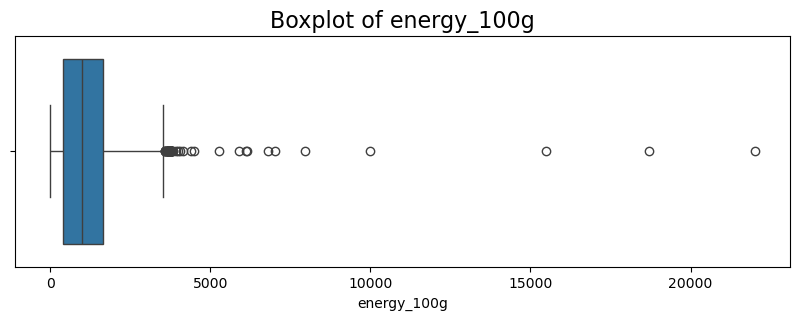

In [48]:
plt.figure(figsize=(10,3))
sns.boxplot(x=X['energy_100g'])
plt.title('Boxplot of energy_100g', fontsize=16)
plt.show()

On constate que la plupart des outliers de droite sur la boxplot sont des valeurs aberrantes. La boxplot est fortement concentrée à gauche (asymétrie à droite), qui sera confirmé dans l'histogramme ci-dessous.

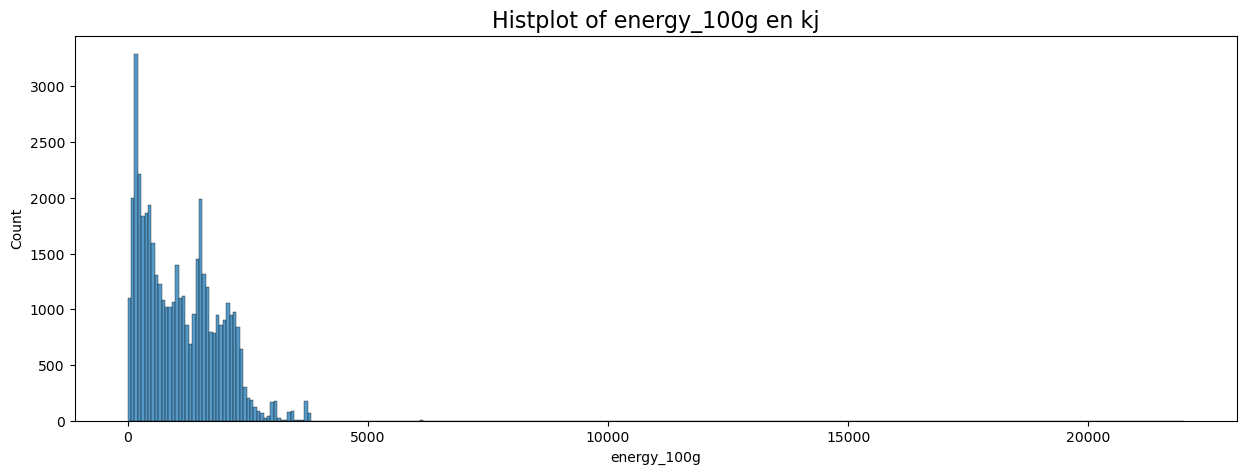

In [50]:
plt.figure(figsize=(15,5))
sns.histplot(data=X, x='energy_100g')
plt.title('Histplot of energy_100g en kj', fontsize=16)
plt.show()

La concentration (étalement/asymétrie à droite) est confirmée dans cette visualisation. 

On constate la présence de 2 pics, signe d'une distribution unimodale. Le plus grand proche de 0 0k, et le 2ème proche de 1400 kj. La présence de ces 2 pics est peut-être liée à des groupes sous-jacents. On peut regarder ce qui se passe si on utilise la variable 'nutrition_grade_fr'.

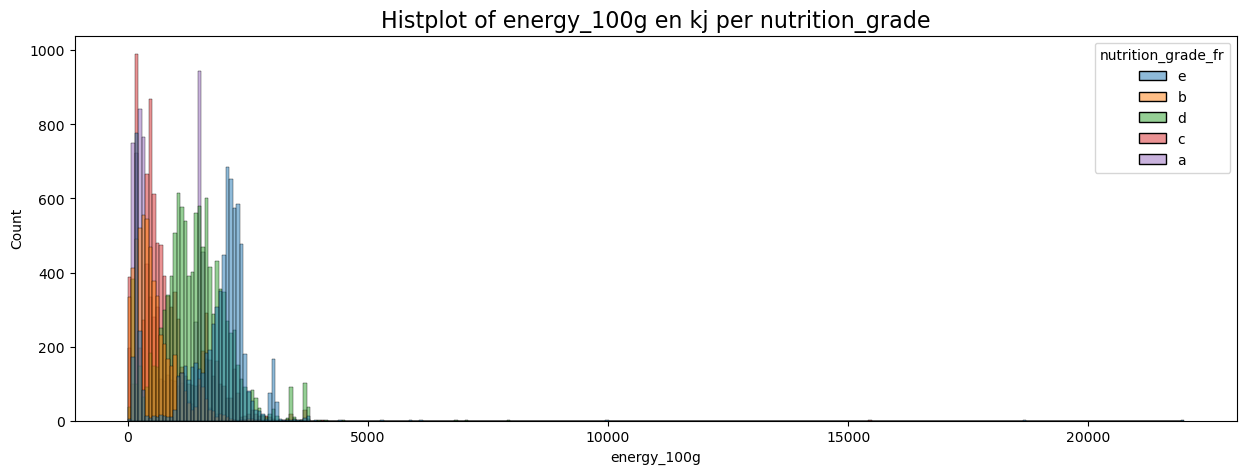

In [52]:
plt.figure(figsize=(15,5))
sns.histplot(data=X, x='energy_100g', hue='nutrition_grade_fr')
plt.title('Histplot of energy_100g en kj per nutrition_grade', fontsize=16)
plt.show()

**Calculer les limites IQR**

On peut aussi regarder la méthode basée sur l'IQR. L'IQR est la différence entre le 25e centile (Q1) et le 75e centile (Q3) des données. Les valeurs :
- inférieures à Q1 - 1,5 * IQR
- ou supérieures à Q3 + 1,5 * IQR

sont considérées comme aberrantes.

In [54]:
# On calcule l'IQR (intervalle interquartile)
Q1 = X['energy_100g'].quantile(0.25)
Q3 = X['energy_100g'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "kj")
print("limite haute :", limite_haute, "kj")

limite basse : 0 kj
limite haute : 3546.5 kj


In [55]:
mask = df['energy_100g'] > limite_haute
print(df.loc[mask, ['code', 'product_name', 'energy_100g']].sort_values(['energy_100g'], ascending=[False]))

                 code                                       product_name  \
176697  2000000045489                                             bubbly   
245311  3596710288755         mini choux goût fromage de chèvre - poivre   
223318  3291960006127  Huiles vierge biologique de Colza - première p...   
178787       20233679                                 Halva with Almonds   
311783  8480017111852                       Chocolate negro sin azúcares   
...               ...                                                ...   
153710  0822078961003                              Huile de Noix de Coco   
264638  4260168150467                                Cocofin aus Kokosöl   
62542   0051500255483                                      Crisco Blends   
19654   0022506135635                                 Virgin coconut oil   
193954  3103220035559                                Les Schtroumpfs P!k   

        energy_100g  
176697      22000.0  
245311      18700.0  
223318      15481.0  

Il y a 272 produits au delà de la limite haute (3546 kj). Mais d'après le site, il existe de très nombreux produits alimentaires qui dépassent cette limite haute, jusqu'à 3 772 kj.

**Calculer le z-score**

Utilisez la méthode du z-score Le z-score mesure de combien d'écarts types une valeur est éloignée de la moyenne de la variable. On considère qu'un z-score supérieur à 2 ou 3 correspond à un outlier.

In [57]:
# On enlève les NaN
sample = df[df['energy_100g'].notnull()].copy()

# Calculer le z-score
sample['z_energy'] = stats.zscore(sample['energy_100g'])
sample.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,...,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,z_energy
190666,3041090070198,http://world-fr.openfoodfacts.org/produit/3041...,loverock,1483100156,2016-12-30T12:15:56Z,1483101510,2016-12-30T12:38:30Z,Blédilait croissance vanille,Lait de suite et aliment lacté liquide pour en...,500ml,"bouteille,plastique","bouteille,plastique","Blédina,Blédilait,Danone","bledina,bledilait,danone","Laits pour bébé,Laits de croissance,Laits arom...","en:beverages,en:dairies,en:dairy-drinks,en:bab...","Boissons,Produits laitiers,Boissons lactées,Al...",NaN,NaN,NaN,NaN,Arômes naturels,en:natural-flavors,Arômes naturels,FR 59.580.030 EC,fr-59-580-030-ec,"50.8,2.583333",NaN,steenvoorde-nord-france,"chalon-sur-saône,france",Intermarché,France,en:france,France,"_lait_ écrémé, eau, lactose (_lait_), matières...","lait, lait, soja, soja",NaN,NaN,NaN,NaN,NaN,NaN,9.0,[ lait-ecreme -> fr:lait-ecreme ] [ lait ->...,"en:e322,en:e306,en:e300,en:e101,en:e333,en:e50...","E322 - Lécithines,E306 - Extrait riche en toco...",1.0,NaN,huile-de-palme,0.0,...,1.4,0.4,NaN,0.07366,0.029000,NaN,0.000063,NaN,1.300000e-06,0.0007,0.000009,0.0082,0.000060,0.00020,0.0008,0.000070,0.000016,NaN,3.000000e-07,0.000004,0.00050,NaN,NaN,0.095,0.045,0.0710,0.050,0.0012,0.0075,0.00060,0.000025,0.000015,0.000015,7.000000e-07,NaN,NaN,0.000015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,1.0,NaN,NaN,-1.043268
197596,3176571194008,http://world-fr.openfoodfacts.org/produit/3176...,openfoodfacts-contributors,1473964958,2016-09-15T18:42:38Z,1483894471,2017-01-08T16:54:31Z,baby croissance 3,Lait de suite pour nourrissons et aliment lact...,1L,"bouteille,plastique","bouteille,plastique","candia,Candia Baby,Sodiaal","candia,candia-baby,sodiaal","Produits laitiers,Laits,Aliments pour bébé,Lai...","en:dairies,en:milks,en:baby-foods,en:baby-milk...","Produits laitiers,Laits,Aliments pour bébé,Lai...",NaN,NaN,France,france,Sans huile de palme,en:palm-oil-free,Sans huile de palme,FR 59.039.030 EC,fr-59-039-030-ec,"50.15,3.283333",NaN,awoingt-nord-france,"Chalon-sur-saône,France","Intermarché,Leclerc",France,en:france,France,"_Lait_ partiellement écrémé, eau, _lactose_, m...","Lait, lactose",NaN,NaN,NaN,NaN,NaN,NaN,8.0,[ lait-partiellement-ecreme -> fr:lait-partie...,"en:e101,en:e300,en:e306,en:e333,en:e331,en:e51...","E101 - Riboflavine,E300 - Acide ascorbique,E30...",0.0,NaN,NaN,1.0,...,NaN,NaN,NaN,0.07620,0.030000,NaN,0.000075,NaN,1.500000e-06,0.0012,0.000004,0.0090,0.000090,0.00019,0.0007,0.000080,0.000015,NaN,2.000000e-07,0.000003,0.00050,NaN,NaN,0.095,0.052,0.0830,0.055,0.0012,0.0070,0.00080,0.0000

In [58]:
mask = sample['z_energy'] > 3
print(sample.loc[mask, ['product_name', 'energy_100g', 'z_energy']].sort_values(['energy_100g'], ascending=[False]))

                                             product_name  energy_100g  \
176697                                             bubbly      22000.0   
245311         mini choux goût fromage de chèvre - poivre      18700.0   
223318  Huiles vierge biologique de Colza - première p...      15481.0   
178787                                 Halva with Almonds       9983.0   
311783                       Chocolate negro sin azúcares       7966.0   
...                                                   ...          ...   
62542                                       Crisco Blends       3590.0   
193954                                Les Schtroumpfs P!k       3573.0   
254692                                 Virgin Coconut Oil       3515.0   
306833                                  Saveur provençale       3510.0   
217959                                Huile Vierge De Lin       3502.0   

         z_energy  
176697  26.079980  
245311  21.963404  
223318  17.947871  
178787  11.089405  
311783   8.

Le calcul du z-score n'est pas non plus pertinent ici. Les produits entre 3 800 kj et 3 500 kj n'ont pas forcément des valeurs aberrantes. On retrouve sensiblement le même nombre de produits.

Je propose de m'appuyer sur le site internet, indiqué plus haut, et déterminer que les valeurs aberrantes se situent au-dessus de 4 000 kj.

**Remplacer les valeurs aberrantes par NaN**

In [61]:
# remplacer dans le dataset
mask = df['energy_100g'] > 4000
df.loc[mask, 'energy_100g'] = np.nan

# regénérer la cible, les features
y, X = generate_target_and_features(df)

In [62]:
X.shape

(55448, 9)

In [63]:
mask = df['energy_100g'] > limite_haute
print(df.loc[mask, ['code', 'product_name', 'energy_100g']].sort_values(['energy_100g'], ascending=[False]))

                 code                           product_name  energy_100g
203685  3245390220660       Rillettes de sardine de Bretagne       4000.0
234726  3473710080032                      Palets pur beurre       3925.0
62532   0051500239131        Crisco All-Vegetable Shortening       3830.0
277355  5400910105201                          Huile de coco       3776.0
310564  8437005613157  Huile d'olive extra vierge biologique       3770.0
...               ...                                    ...          ...
153710  0822078961003                  Huile de Noix de Coco       3630.0
19654   0022506135635                     Virgin coconut oil       3590.0
62542   0051500255483                          Crisco Blends       3590.0
264638  4260168150467                    Cocofin aus Kokosöl       3590.0
193954  3103220035559                    Les Schtroumpfs P!k       3573.0

[257 rows x 3 columns]


On voit qu'il n'y a plus de valeur au-delà de 4000 kj

**Traiter les autres types de valeur aberrante**

D'après ChatGPT : "il est tout à fait possible d'avoir un produit alimentaire avec une valeur énergétique (énergie) en kilojoules (kJ) supérieure à zéro et une teneur en protéines de zéro gramme.
La raison en est que l'énergie d'un aliment provient de trois principaux macronutriments : 
- les glucides,
- les lipides (graisses)
- et les protéines.

Donc si un aliment ne contient pas de protéines, il peut quand même contenir des glucides et/ou des lipides, qui contribuent également à son apport énergétique.

Pour calculer l'énergie en kilojoules (kJ) d'un aliment, il faut connaître la quantité de chaque macronutriment (glucides, protéines, lipides) et utiliser les coefficients énergétiques correspondants :
- Glucides : 1 g de glucides = 17 kJ
- Protéines : 1 g de protéines = 17 kJ
- Lipides : 1 g de lipides = 37 kJ
"



In [67]:
# rechercher les produits dont l'energy_100g = 0, alors qu'il y a des protéines, ou des lipides, ou des glucides
mask = (df['energy_100g'] == 0) & ((df['proteins_100g'] > 0) | (df['fat_100g'] > 0) | (df['carbohydrates_100g'] > 0))
print(df.loc[mask, ['code', 'product_name', 'energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g']])

                 code                                       product_name  \
67499   0064420006271                                         Sour Cream   
23711   0028400040037                                             Fritos   
309318  8427603020532                               Tomates Tipo Canario   
118415  0613008721916                  Decaf-Zero Green Tea with Ginseng   
16019   0020601407893  Heinen's Organic Unsweetened With Lemon  Iced ...   
310147  8436038770103                           Pulpa de mango congelada   
245997  3596710355389                                   Planet Cola Zéro   
242507  3564700629222  DéliDelo sans sucres à l'eau de source au pamp...   
310145  8436038770066                       Pulpa de guanábana congelada   
262451  4060800134042                                     V Water Shield   
195994  3163937310004                                     Sensation Anis   
66803   0059749887649                                Peas assorted sizes   
230216  3388

Le traitement de ces cas là ne peut pas être identique, car il y a très certainement un arrondi à zéro de l'energy_100g qui est réalisé. Par exemple pour le dernier produit de liste, protéines = 0,1, entraîne une energy = 0 par arrondi.

Par contre pour les 2 premiers produits (Sour cream, et fritos), il est clair que l'energy ne peut pas être = 0.

Voici la liste des codes produits ci-dessus dont la valeur 0 pour l'energy peut être considérée comme aberrante :
- 0064420006271
- 0028400040037
- 8427603020532
- 8436038770103
- 8436038770066
- 0059749887649
- 01275900
- 0894773001155
- 0894773001896



Remplacer la valeur d'énergie par la valeur calculée avec la formule : energy = 17 *proteins + 37 * fat + 17 * carbohydrates

In [70]:
mask = df['code'].isin(["0064420006271","0028400040037","8427603020532","8436038770103","8436038770066","0059749887649","01275900","0894773001155","0894773001896"])
df.loc[mask, 'energy_100g']

67499     0.0
23711     0.0
309318    0.0
310147    0.0
310145    0.0
66803     0.0
172837    0.0
111493    0.0
172853    0.0
Name: energy_100g, dtype: float64

In [71]:
df.loc[mask, 'energy_100g'] = 17 * df['proteins_100g'] + 17 * df['carbohydrates_100g'] + 37 * df['fat_100g'] 

In [72]:
df.loc[mask, 'energy_100g']

67499     725.00
23711     676.00
309318     95.80
310147    289.00
310145    255.00
66803     259.60
172837     19.21
111493     94.52
172853     19.21
Name: energy_100g, dtype: float64

Rechercher les produits dont l'energy_100g > 0, alors qu'il n'y a aucune protéine, lipide, et glucide

In [74]:
# rechercher les produits dont l'energy_100g > 0, alors qu'il n'y a aucunes protéines, lipides, et glucides
mask = (df['energy_100g'] > 0) & ((df['proteins_100g'] == 0) & (df['fat_100g'] == 0) & (df['carbohydrates_100g'] == 0))
print(df.loc[mask, ['code', 'product_name', 'energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g']])

                 code                                       product_name  \
280341  5449000050229                                 Coca-cola light 2L   
280356  5449000056665         Coca-Cola Light - sans caféine, sans sucre   
280473  5449000169358                   Coca Cola Zéro sans caféine 1.5L   
318340       90376863                   red bull zero calories - redbull   
210024  3256221107982                Pétillante, saveur citon-citon vert   
269201  5000112558265                                     Coca-Cola Zéro   
251876  3760036481774            Muscovado pur sucre de canne non rafiné   
198272  3179732368942                        Perrier citron vert, limoen   
238917  3560070592975                                      Saveur Cassis   
192056  3068320055008                                              Evian   
203893  3245412438523                         Iced Tea Zéro saveur Pêche   
280490  5449000195364                              Coca-Cola Zero Cherry   
280453  5449

Tout ces produits sont des boissons, plutôt de type light, ce qui explique les valeurs nulles des protéines, des lipides, et des glucides.

En regardant sur internet pour le Coca cola light par exemple, l'energy devrait être de 1 kj.

Il y a quand même 3 produits qui questionnent car leurs valeurs sont très élevées: 
- 3760036481774 (Muscovado pur sucre de canne non rafiné) -> 1611 kj . Ce produit devrait avoir 100g de carbohydrate (et de sucres) d'après internet
- 192056 (Evian) -> 2787 kj . Ce produit devrait avoir un energy = 0 kj
- 93613910 (Extra - Peppermint) -> 915 kj . Ce produit devrait avoir 62g de carbohydrates (et de sucres) d'après internet

On pourra traiter ces 3 produits uniquement, en mettant la bonne valeur pour les carbohydrates et le sucre.

Les autres valeurs sont certainement liées à des problèmes d'arrondi de valeur à l'unité en dessous 0.

Remplacer les carbohydrates des 2 produits suivants:

In [77]:
mask = df['code'].isin(["3760036481774", "93613910"])
df.loc[mask, 'carbohydrates_100g'] = 100
df.loc[mask, 'sugars_100g'] = 100
mask = df['code'].isin(["93613910"])
df.loc[mask, 'carbohydrates_100g'] = 62
df.loc[mask, 'sugars_100g'] = 62

Mettre l'energie à 0 du produit suivant : 

In [79]:
mask = df['code'].isin(["3068320055008"])
df.loc[mask, 'energy_100g'] = 0

**Regénérer la cible, les features**

In [81]:
# regénérer la cible, les features
y, X = generate_target_and_features(df)

df.shape

(55448, 162)

In [82]:
X.shape

(55448, 9)

In [83]:
y.shape

(55448,)

**Visualiser la distribution de la variable après traitement des valeurs aberrantes**

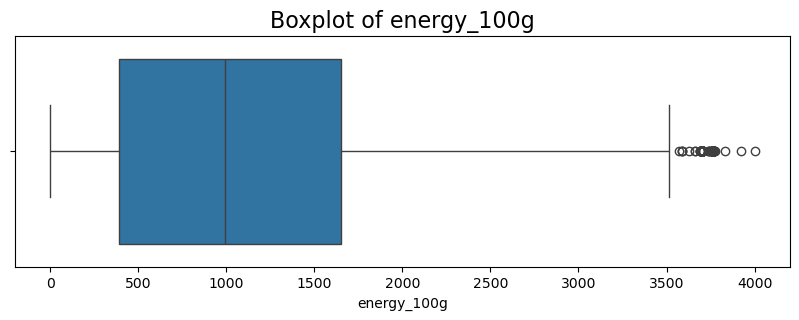

In [85]:
plt.figure(figsize=(10,3))
sns.boxplot(x=X['energy_100g'])
plt.title('Boxplot of energy_100g', fontsize=16)
plt.show()

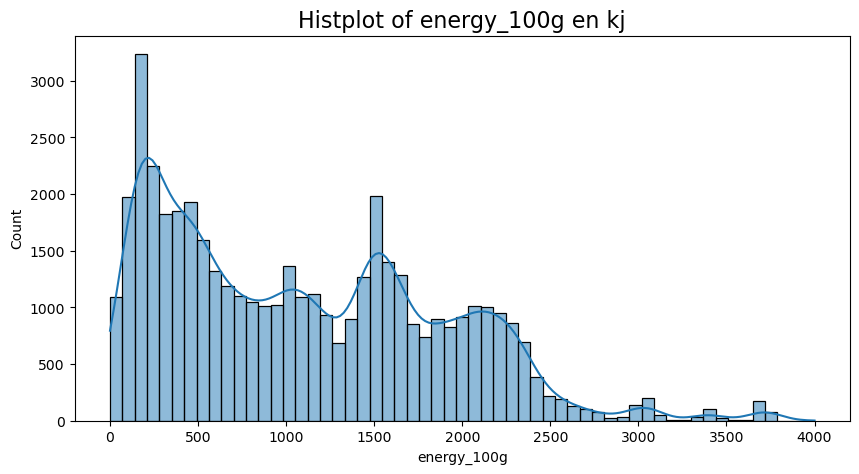

In [86]:
plt.figure(figsize=(10,5))
sns.histplot(data=X, x='energy_100g', kde=True)
plt.title('Histplot of energy_100g en kj', fontsize=16)
plt.show()

La courbe de distribution s'ajuste correctement à l'histogramme.

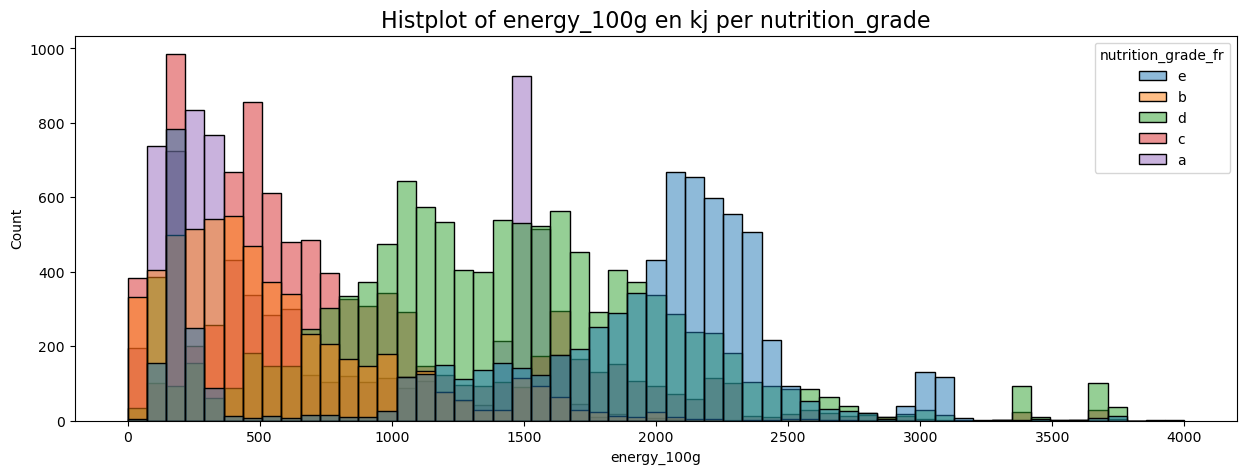

In [88]:
plt.figure(figsize=(15,5))
sns.histplot(data=X, x='energy_100g', hue='nutrition_grade_fr')
plt.title('Histplot of energy_100g en kj per nutrition_grade', fontsize=16)
plt.show()

In [89]:
X.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sugars_100g,saturated-fat_100g,fiber_100g
count,45217.000000,44856.000000,43600.000000,43252.000000,42834.000000,42697.000000,42539.000000,27540.000000
mean,1090.835556,7.521530,13.334425,27.883429,0.880374,13.240657,5.478628,2.728282
std,783.840352,7.211233,17.001147,27.327219,2.811570,18.517551,8.402184,3.870259
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000
25%,389.000000,1.700000,1.200000,4.400000,0.070000,1.100000,0.300000,0.400000
50%,994.000000,6.000000,6.600000,14.500000,0.500000,4.300000,2.000000,1.700000
75%,1651.000000,10.600000,21.600000,53.300000,1.200000,17.000000,7.700000,3.500000
max,4000.000000,86.000000,380.000000,190.000000,297.600000,100.000000,210.000000,86.200000


### 2.3 - Feature "proteins_100g"

Une valeur 0 pour les protéines est aberrante seulement si l'energie est différente de 0, et les fat / carborhydrates sont = 0. Mais ce cas vient d'être traité plus haut.

La valeur max 80 n'est pas aberrante à première vue. D'après le site internet informationsnutritionnelles.fr (lien : https://informationsnutritionnelles.fr/proteines ), les protéines peuvent monter jusqu'à 87.6g pour un aliment de 100g. Donc rien d'aberrant. Sauf qu'en général il s'agit de produits complémentaires hyper protéinés, ou de préparation de cuisine.

**Visualiser la distribution de la variable**

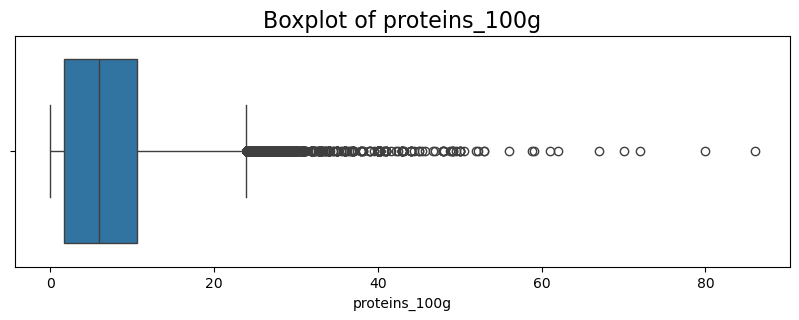

In [93]:
plt.figure(figsize=(10,3))
sns.boxplot(x=X['proteins_100g'])
plt.title('Boxplot of proteins_100g', fontsize=16)
plt.show()

On constate la présence de nombreux outliers, une forte concentration à gauche.

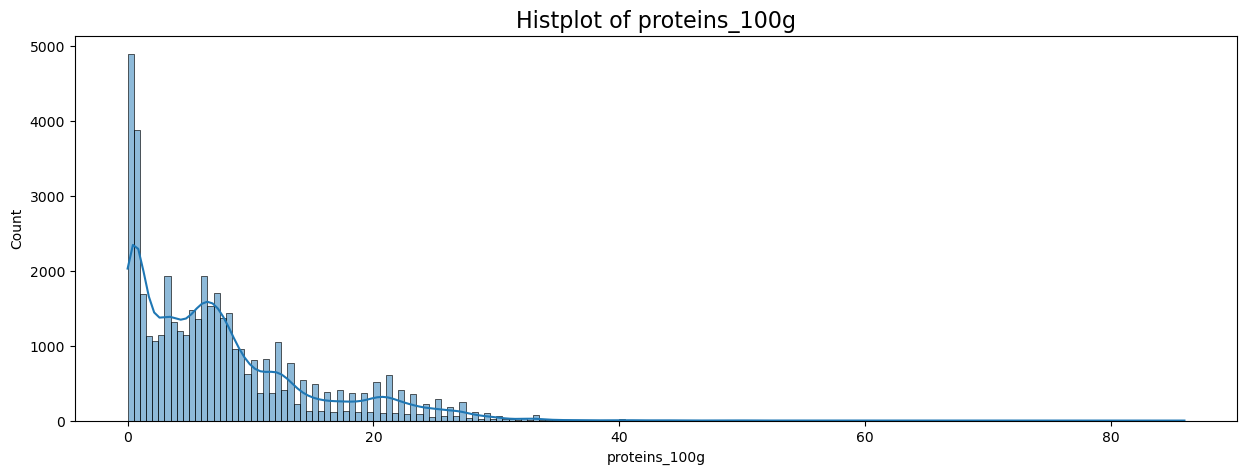

In [95]:
plt.figure(figsize=(15,5))
sns.histplot(data=X, x='proteins_100g', kde=True)
plt.title('Histplot of proteins_100g', fontsize=16)
plt.show()

On constate une distribution assez similaire à celle de l'energy_100g. Présence de 2 pics : un plus gros, 0-0.5, et un plus petit aux alentours de 6. 

Asymétrie à droite (étalement à droite). La loi de distribution s'ajuste correctement.

**Calculer les limites IQR**

In [98]:
# On calcule l'IQR (intervalle interquartile)
Q1 = X['proteins_100g'].quantile(0.25)
Q3 = X['proteins_100g'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "kj")
print("limite haute :", limite_haute, "kj")

limite basse : 0 kj
limite haute : 23.950000000000003 kj


Combien de produits concernés, et lesquels, sont au-dessus de la limite haute ?

In [100]:
mask = df['proteins_100g'] > limite_haute
print(df.loc[mask, ['code', 'product_name', 'proteins_100g']].sort_values(['proteins_100g'], ascending=[False]))

                 code                       product_name  proteins_100g
193318  3092718618971                       Sirop Fraise           86.0
264863  4260402480985       Seitan-Basis rein pflanzlich           80.0
242107  3564700511930           Chewing-gum menthe verte           72.0
281699  5707312003129        Pronto® OGGI Melon Cocktail           70.0
281697  5707312003105            Pronto® OGGI Peppermint           67.0
...               ...                                ...            ...
201761  3222476450562  Saveurs d'Ailleurs Queso Manchego           24.0
216791  3263859462215  Jambon Cru Fumé de la Forêt Noire           24.0
263128  4104060028052                          Bioländer           24.0
261063  4021500086949         Grünländer Chili & Paprika           24.0
266852  4600935010486                   Чечевица красная           24.0

[1769 rows x 3 columns]


On constate des valeurs aberrantes, notamment pour le chewing-gum menthe verte, 72g de protéines, or d'après internet c'est 0g de protéines.

Le seitan pourrait monter à 75g sur internet.

Le poulet à 27g.

C'est difficile de se faire une idée générale. Voyons avec un diagramme de distribution, filtré sur les produits au-dessus de la limite haute :

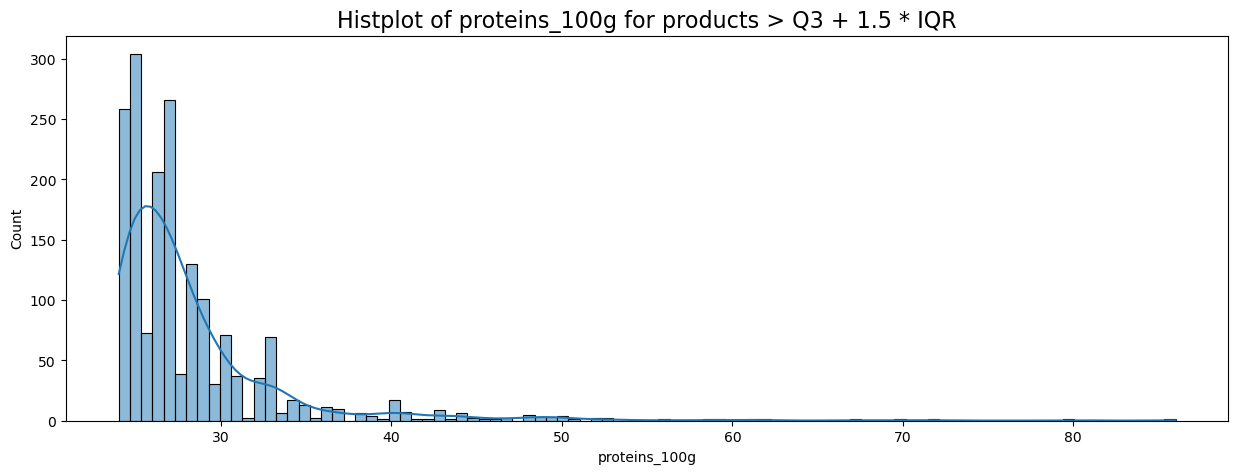

In [102]:
plt.figure(figsize=(15,5))
sns.histplot(data=X[mask], x='proteins_100g', kde=True)
plt.title('Histplot of proteins_100g for products > Q3 + 1.5 * IQR', fontsize=16)
plt.show()

On constate une forte diminution du nombre de produits au-delà de 50g de protéines

In [104]:
mask = df['proteins_100g'] > 50
print("Liste des produits de plus de 50g de protéines :", df.loc[mask, ['code', 'product_name', 'proteins_100g']].sort_values(['proteins_100g'], ascending=[False]))

Liste des produits de plus de 50g de protéines :                  code                                       product_name  \
193318  3092718618971                                       Sirop Fraise   
264863  4260402480985                       Seitan-Basis rein pflanzlich   
242107  3564700511930                           Chewing-gum menthe verte   
281699  5707312003129                        Pronto® OGGI Melon Cocktail   
281697  5707312003105                            Pronto® OGGI Peppermint   
313012  8692809031006                                           Mir Coco   
250619  3700531201538                                Sucette au chocolat   
282768  5999563456568                                  Bio Chlorella Por   
255538  3770004620081      Les Insectes Apéritifs Saveur Méditerranéenne   
308823  8422584017069  Milanesas de soja texturizada &quot;El Granero...   
312616  8594055300151                                            Chicken   
176569  2000000041639        Bulk Powde

La valeur pour le sirop de fraise, sucette au chocolat, et les chewing-gum sont aberrantes

**Calculer le z-score**

In [107]:
# On enlève les NaN
sample = df[df['proteins_100g'].notnull()].copy()

# Calculer le z-score
sample['z_proteins'] = stats.zscore(sample['proteins_100g'])
sample.head()

mask = sample['z_proteins'] > 3
print(sample.loc[mask, ['product_name', 'proteins_100g', 'z_proteins']].sort_values(['proteins_100g'], ascending=[False]))

                                     product_name  proteins_100g  z_proteins
193318                               Sirop Fraise           86.0   10.882930
264863               Seitan-Basis rein pflanzlich           80.0   10.050886
242107                   Chewing-gum menthe verte           72.0    8.941493
281699                Pronto® OGGI Melon Cocktail           70.0    8.664145
281697                    Pronto® OGGI Peppermint           67.0    8.248123
...                                           ...            ...         ...
206760                             Arachide coque           29.4    3.033977
207055                             Mon Jambon Sec           29.4    3.033977
310371         Fouet Extra &quot;Le Catalan&quot;           29.3    3.020109
209109  Saucisson sec pur porc supérieur Pyrénées           29.3    3.020109
207054                      Jambon cru fumé Speck           29.2    3.006242

[393 rows x 3 columns]


Un z-score de 3 correspondrait à 29.2g de protéines.

On voit qu'au dessus du z-score de 3, ou au-dessus de la limite calculée avec l'IQR, il y a de nombreux produits pour lesquels la valeur n'est pas aberrante. Pour identifier les valeurs aberrantes, il faudrait vérifier les valeurs de chaque produit au dessus du z-score, et voir s'il est abérrante ou non. Compte tenu du contexte de l'analyse, il serait sage de laisser ces valeurs inchangées qui semblent correctes à première vue. 

Je vais juste corriger le produit Chewing-gum menthe verte, le sirop de fraise, et sucette au chocolat, qui ont des valeurs aberrantes évidentes, et pour lesquelles je mettrai la valeur trouvée sur internet :

In [110]:
# remplacer dans le dataset
mask = df['code'] == '3564700511930'
df.loc[mask, ['proteins_100g']] = 0

mask = df['code'] == '3092718618971'
df.loc[mask, ['proteins_100g']] = 0

mask = df['code'] == '3700531201538'
df.loc[mask, ['proteins_100g']] = 6.4

# regénérer la cible, les features
y, X = generate_target_and_features(df)
X.shape

(55448, 9)

### 2.3 - Features "fat_100g" et "saturated-fat_100g"

In [112]:
X.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sugars_100g,saturated-fat_100g,fiber_100g
count,45217.000000,44856.000000,43600.000000,43252.000000,42834.000000,42697.000000,42539.000000,27540.000000
mean,1090.835556,7.516790,13.334425,27.883429,0.880374,13.240657,5.478628,2.728282
std,783.840352,7.191012,17.001147,27.327219,2.811570,18.517551,8.402184,3.870259
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000
25%,389.000000,1.700000,1.200000,4.400000,0.070000,1.100000,0.300000,0.400000
50%,994.000000,6.000000,6.600000,14.500000,0.500000,4.300000,2.000000,1.700000
75%,1651.000000,10.600000,21.600000,53.300000,1.200000,17.000000,7.700000,3.500000
max,4000.000000,80.000000,380.000000,190.000000,297.600000,100.000000,210.000000,86.200000


**Remplacer les valeurs aberrantes au-dessus de 100g par NaN**

Rechercher les produits concernés:

In [115]:
mask = (df['fat_100g'] > 100) | (df['saturated-fat_100g'] > 100)
print(df.loc[mask, ['code', 'product_name', 'fat_100g', 'saturated-fat_100g']].sort_values(['fat_100g'], ascending=[False]))

                 code                                product_name  fat_100g  \
245311  3596710288755  mini choux goût fromage de chèvre - poivre     380.0   
305054  8032942610032                    Graine de couscous moyen     105.0   
303101  8005305900255                    Ekstra Jomfru Olivenolie     101.0   

        saturated-fat_100g  
245311               210.0  
305054                 0.3  
303101                15.0  


Remplacer les valeurs par NaN

In [117]:
# remplacer dans le dataset
mask = df['code'] == '3596710288755'
df.loc[mask, ['fat_100g', 'saturated-fat_100g']] = np.nan

mask = df['code'].isin(['8032942610032', '8005305900255'])
df.loc[mask, 'fat_100g'] = np.nan

# regénérer la cible, les features
y, X = generate_target_and_features(df)
X.shape

(55448, 9)

In [118]:
X.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sugars_100g,saturated-fat_100g,fiber_100g
count,45217.000000,44856.000000,43597.000000,43252.000000,42834.000000,42697.000000,42538.000000,27540.000000
mean,1090.835556,7.516790,13.321901,27.883429,0.880374,13.240657,5.473820,2.728282
std,783.840352,7.191012,16.899877,27.327219,2.811570,18.517551,8.343559,3.870259
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000
25%,389.000000,1.700000,1.200000,4.400000,0.070000,1.100000,0.300000,0.400000
50%,994.000000,6.000000,6.600000,14.500000,0.500000,4.300000,2.000000,1.700000
75%,1651.000000,10.600000,21.600000,53.300000,1.200000,17.000000,7.700000,3.500000
max,4000.000000,80.000000,100.000000,190.000000,297.600000,100.000000,100.000000,86.200000


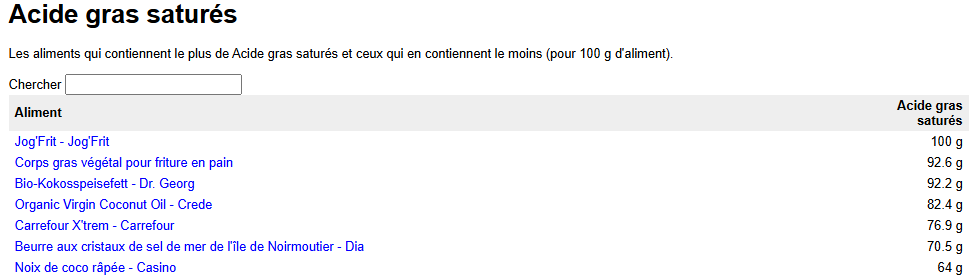

Les acides gras saturés peuvent potentiellement monter jusqu'à 100g. Mais on ne trouve que 4 produits sur internet au-dessus de 80g. D'après chatGPT, au-dessus de 90 est une valeur aberrante, car c'est la valeur max pour 100g d'huile de palme ou d'huile de coco.

On peut donc raisonablement remplacer les valeurs de saturated-fat_100g quand elle dépasse 90g:

**Remplacer les valeurs aberrantes de saturated-fat_100g au-dessus de 90g par NaN**

Rechercher les produits concernés : 

In [123]:
mask = df['saturated-fat_100g'] > 90
print(df.loc[mask, ['code', 'product_name', 'saturated-fat_100g', 'fat_100g']].sort_values(['fat_100g'], ascending=[False]))

                 code                                  product_name  \
203402  3245270001044              Huile vierge de Noix de Coco bio   
223363  3291960013040  Huile de noix de coco biologique goût neutre   
115370  0411015621416                            extra virgin cocos   
275205  5158418187631                  Végétaline (offre familiale)   
315570  8718182611298                                     Kokosolie   
177219       20022082                             Frites & Fritures   
264638  4260168150467                           Cocofin aus Kokosöl   
261373       40264479                                     Kokosfett   
184439       26008028                                      Jog'Frit   
265119  4305615443041                                 Kokosöl nativ   
280238  5425600102483                       Huile de coco - Bee&Cee   
258204  4006040216278                          Huile vierge de Coco   
223303  3291960001542                  Huile vierge de noix de coco   
313907

Remplacer les valeurs des produits trouvés par NaN :

In [125]:
mask = df['saturated-fat_100g'] > 90
df.loc[mask, 'saturated-fat_100g'] = np.nan

# regénérer la cible, les features
y, X = generate_target_and_features(df)
X.shape

(55448, 9)

**Traiter les valeurs aberrantes des cas où saturated-fat_100g > fat_100g**

La valeur de la variable fat_100g pourrait être aberrante si la valeur de la variable saturated-fat_100g > fat_100g.

In [128]:
mask = df['saturated-fat_100g'] > df['fat_100g']
print(df.loc[mask, ['code', 'product_name', 'fat_100g', 'saturated-fat_100g']].sort_values(['fat_100g'], ascending=[False]))

                 code                                       product_name  \
177333       20031244                                   Macarons de coco   
252224  3760056264630               Mozzarella Spécial Cuisine (23 % MG)   
253699  3760122966109      Le vrai cookie avec gros morceaux de chocolat   
206159  3250391072781                                         Léger Doux   
220630  3272770088770                             Le coffret du Fromager   
230843  3396411221309                             Chocolat Noir Mendiant   
266550  4388844182677                                  Butter Croissants   
298783  7622210497383                                         Dairy milk   
205751  3250390600671                                 Adelie Bac Vanille   
224179  3302741597021     Les St Jacques au Noilly & Riz Basmati cuisiné   
274767  5060224881163                                      Cheese salad    
232989  3438860006646                                         Choconeige   
205678  3250

Globalement l'écart entre les 2 variables est très faible, hormis les produits suivants donc l'écart questionnent :
- 3760075290108 (vu sur internet, fat_100g devrait être égal à 22)
- 3250390491064 (vu sur internet, 0.6g pour saturated-fat)
- 3261055931542 (vu sur internet, 1.9g pour saturated-fat)
- 3250390600671 (vu sur internet 6,6g fat, 4g saturated-fat)

Pour les autres cas, je propose de mettre la valeur NaN  pour saturated-fat_100g.

Mettre les bonnes valeurs :

In [130]:
mask = df['code'] == '3760075290108'
df.loc[mask, 'fat_100g'] = 22

mask = df['code'] == '3250390491064'
df.loc[mask, 'saturated-fat_100g'] = 0.6

mask = df['code'] == '3261055931542'
df.loc[mask, 'saturated-fat_100g'] = 1.9

mask = df['code'] == '3250390600671 '
df.loc[mask, 'saturated-fat_100g'] = 4
df.loc[mask, 'fat_100g'] = 6.6

In [131]:
mask = df['saturated-fat_100g'] > df['fat_100g']
df.loc[mask, 'saturated-fat_100g'] = np.nan

In [132]:
# regénérer la cible, les features
y, X = generate_target_and_features(df)
X.shape

(55448, 9)

**Visualiser la distribution de la variable fat_100g**

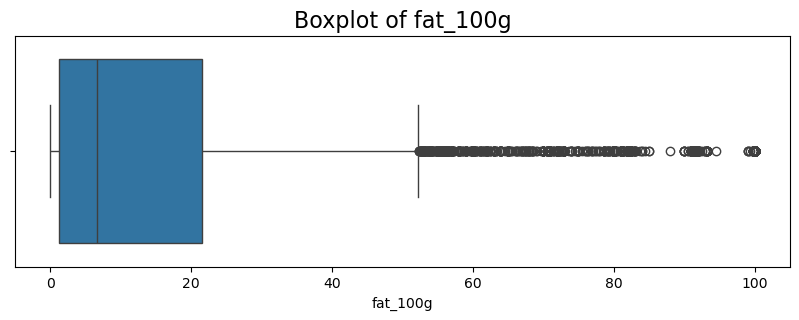

In [134]:
plt.figure(figsize=(10,3))
sns.boxplot(x=X['fat_100g'])
plt.title('Boxplot of fat_100g', fontsize=16)
plt.show()

Présence d'outliers, mais au vu de l'analyse précédentes des valeurs aux limites, ces outliers ne semblent pas des valeurs aberrantes.

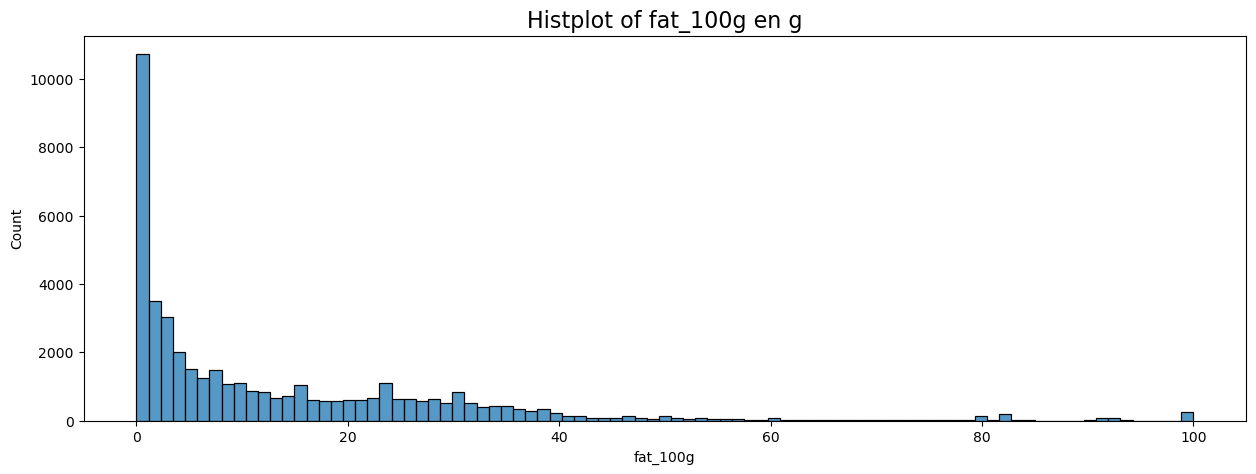

In [136]:
plt.figure(figsize=(15,5))
sns.histplot(data=X, x='fat_100g')
plt.title('Histplot of fat_100g en g', fontsize=16)
plt.show()

Distribution asymétrique droite (concentration à gauche - étalement à droite), unimodale. 

Le calcul de l'IQR ou du z-score ne semble par pertinent ici pour identifier les valeurs aberrantes, car elles semblent toutes cohérentes.

**Visualiser la distribution de la variable saturated-fat_100g**

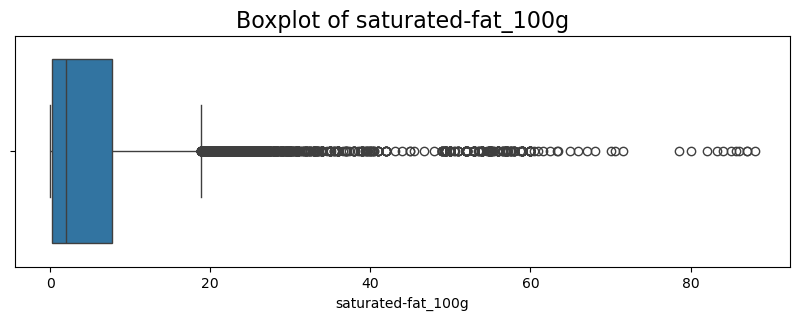

In [139]:
plt.figure(figsize=(10,3))
sns.boxplot(x=X['saturated-fat_100g'])
plt.title('Boxplot of saturated-fat_100g', fontsize=16)
plt.show()

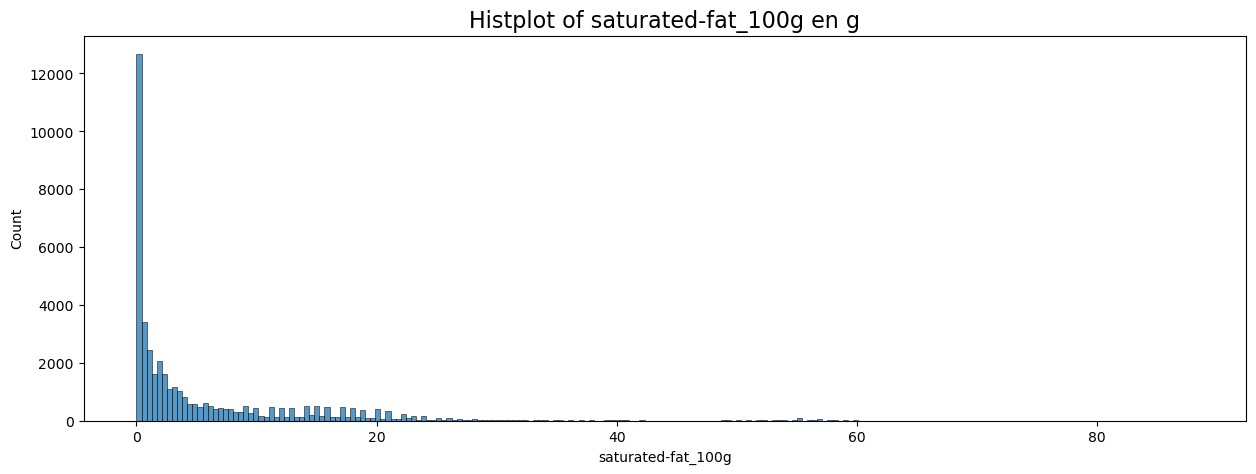

In [140]:
plt.figure(figsize=(15,5))
sns.histplot(data=X, x='saturated-fat_100g')
plt.title('Histplot of saturated-fat_100g en g', fontsize=16)
plt.show()

### 2.4 - Features "carbohydrates_100g" et "sugars_100g"

In [143]:
X.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sugars_100g,saturated-fat_100g,fiber_100g
count,45217.000000,44856.000000,43597.000000,43252.000000,42834.000000,42697.000000,42462.000000,27540.000000
mean,1090.835556,7.516790,13.322405,27.883429,0.880374,13.240657,5.435640,2.728282
std,783.840352,7.191012,16.899808,27.327219,2.811570,18.517551,8.134255,3.870259
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000
25%,389.000000,1.700000,1.200000,4.400000,0.070000,1.100000,0.300000,0.400000
50%,994.000000,6.000000,6.600000,14.500000,0.500000,4.300000,2.000000,1.700000
75%,1651.000000,10.600000,21.600000,53.300000,1.200000,17.000000,7.700000,3.500000
max,4000.000000,80.000000,100.000000,190.000000,297.600000,100.000000,88.000000,86.200000


**Remplacer par NaN les valeurs négatives de sugars_100g :**

In [145]:
mask = df['sugars_100g'] < 0
print(df.loc[mask, 'sugars_100g'])
df.loc[mask, 'sugars_100g'] = np.nan

195761   -0.1
Name: sugars_100g, dtype: float64


In [146]:
print(df.loc[mask, 'sugars_100g'])

195761   NaN
Name: sugars_100g, dtype: float64


**Remplacer par NaN les valeurs > 100g de carbohydrates_100g:**

In [148]:
mask = df['carbohydrates_100g'] > 100
print(df.loc[mask, 'carbohydrates_100g'])
df.loc[mask, 'carbohydrates_100g'] = np.nan

234726    106.0
245311    190.0
317635    139.0
Name: carbohydrates_100g, dtype: float64


In [149]:
print(df.loc[mask, 'carbohydrates_100g'])

234726   NaN
245311   NaN
317635   NaN
Name: carbohydrates_100g, dtype: float64


**Regéner la cible, le dataset, les features**

In [151]:
# regénérer la cible, les features
y, X = generate_target_and_features(df)
X.shape

(55448, 9)

**Identifier les produits dont sugars_100g > carbohydrates_100g**

In [153]:
mask = df['carbohydrates_100g'] < df['sugars_100g']
print(df.loc[mask, ['code', 'product_name', 'carbohydrates_100g', 'sugars_100g']])

                 code                                       product_name  \
209122  3254568649813        Darnes de saumon label rouge d'Écosse farci   
18955   0021357020138  Hickory Farms® Our Signature Beef Summer Sausa...   
190361  3038680053044                                  Emincés de Saumon   
215452  3263851394118                                           Girolles   
217257  3263859848811                         Sauté de légumes au poulet   
67359   0063351049005                                Rôti de bœuf au jus   
222045  3278690085646                         Emprésuré Chocolat intense   
280086  5425008346618                                 Noisette pétillant   
181062       20681593   Sauté de Kangourou mariné au vin rouge et épices   
66912   0060383998622                      Milk chocolate with hazelnuts   
202818  3230890758386                    L'Extra de Poulet Grillé Nature   
212665  3257981665248         10 œufs de poules élevées en plein air Bio   
194938  3123

Il y a beaucoup de produits concernés, trop pour des corrections manuelles. En plus il est difficile de savoir lequel des 2 est bon ou faux. On va donc mettre NaN pour les 2 variables.

**Remplacer les valeurs de carbohydrates_100g et sugars_100g, par NaN, quand sugars_100g > carbohydrates_100g**

In [156]:
mask = df['carbohydrates_100g'] < df['sugars_100g']
df.loc[mask, ['carbohydrates_100g', 'sugars_100g']] = np.nan

**Regénérer la cible, les features**

In [158]:
# regénérer la cible, les features
y, X = generate_target_and_features(df)
X.shape

(55448, 9)

**Visualiser la distribution de la variable**

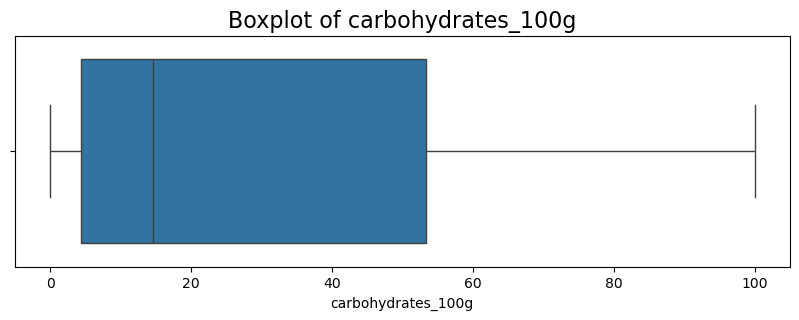

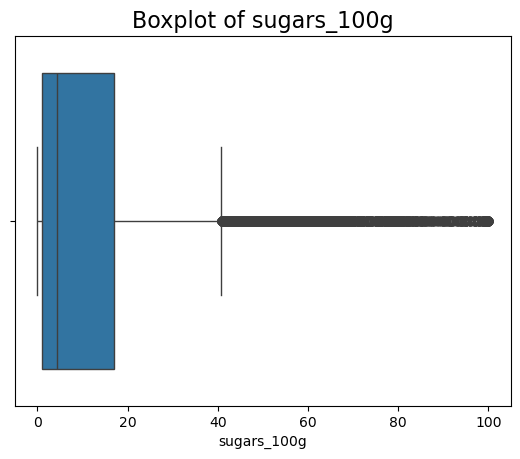

In [160]:
plt.figure(figsize=(10,3))
sns.boxplot(x=X['carbohydrates_100g'])
plt.title('Boxplot of carbohydrates_100g', fontsize=16)
plt.show()

sns.boxplot(x=X['sugars_100g'])
plt.title('Boxplot of sugars_100g', fontsize=16)
plt.show()

Beaucoup d'ouliers, mais ils ne semblent pas être aberrants.

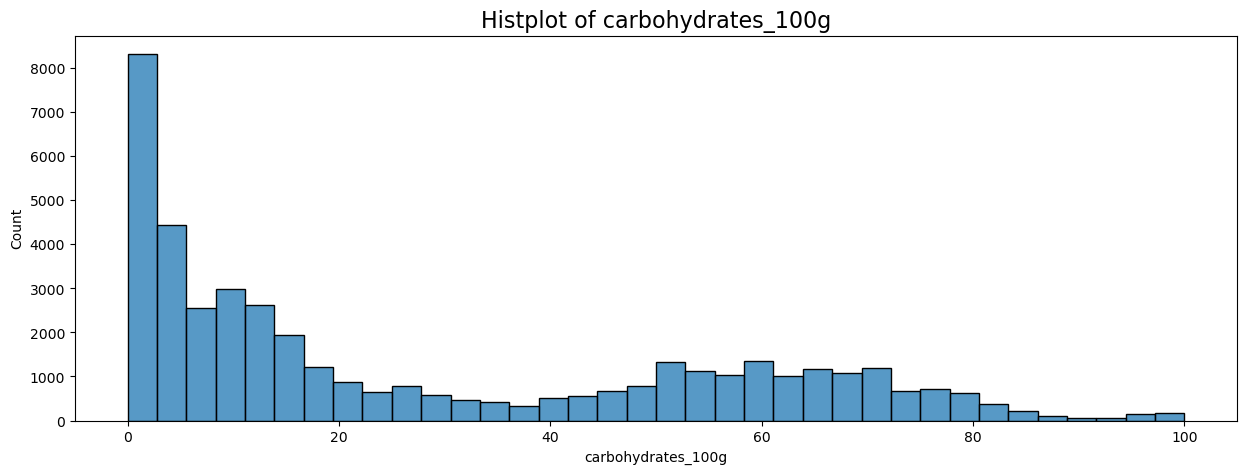

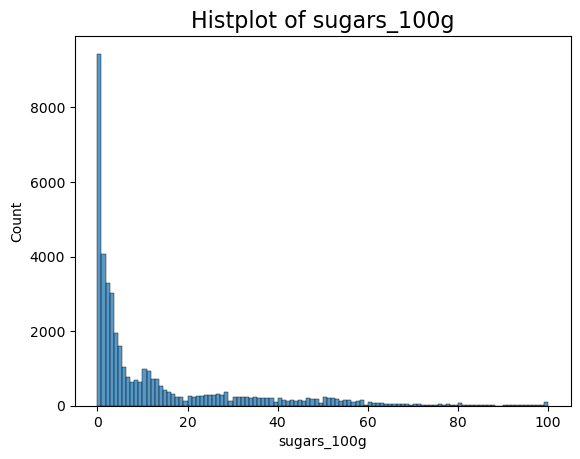

In [162]:
plt.figure(figsize=(15,5))
sns.histplot(data=X, x='carbohydrates_100g')
plt.title('Histplot of carbohydrates_100g', fontsize=16)
plt.show()

sns.histplot(data=X, x='sugars_100g')
plt.title('Histplot of sugars_100g', fontsize=16)
plt.show()

### 2.5 - Features "salt_100g"

In [164]:
X.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sugars_100g,saturated-fat_100g,fiber_100g
count,45217.000000,44856.000000,43597.000000,43167.000000,42834.000000,42614.000000,42462.000000,27540.000000
mean,1090.835556,7.516790,13.322405,27.904642,0.880374,13.238621,5.435640,2.728282
std,783.840352,7.191012,16.899808,27.311663,2.811570,18.507919,8.134255,3.870259
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,389.000000,1.700000,1.200000,4.400000,0.070000,1.100000,0.300000,0.400000
50%,994.000000,6.000000,6.600000,14.600000,0.500000,4.310000,2.000000,1.700000
75%,1651.000000,10.600000,21.600000,53.350000,1.200000,17.000000,7.700000,3.500000
max,4000.000000,80.000000,100.000000,100.000000,297.600000,100.000000,88.000000,86.200000


**Remplacer les valeurs de la variable salt_100g > 100g par NaN:**

In [166]:
mask = df['salt_100g'] > 100
print(df.loc[mask, 'salt_100g'])
df.loc[mask, 'salt_100g'] = np.nan

232239    211.00
274767    297.60
176694    276.86
Name: salt_100g, dtype: float64


In [167]:
# regénérer la cible, les features
y, X = generate_target_and_features(df)
X.shape

(55448, 9)

**Visualiser la distribution de la variable**

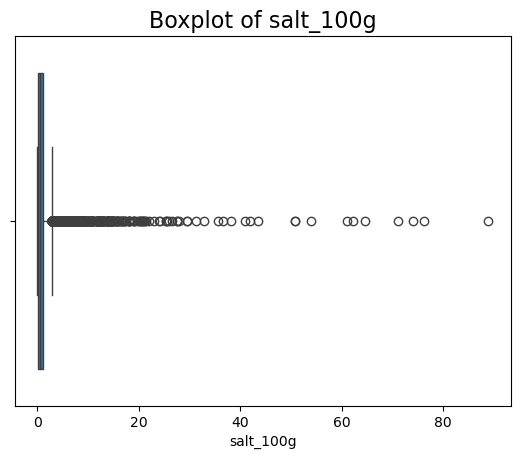

In [169]:
sns.boxplot(x=X['salt_100g'])
plt.title('Boxplot of salt_100g', fontsize=16)
plt.show()

Les outliers ne sont à priori pas des valeurs aberrantes

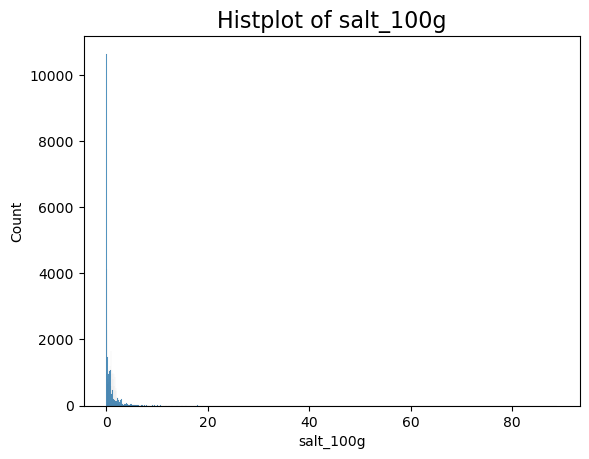

In [171]:
sns.histplot(data=X, x='salt_100g')
plt.title('Histplot of salt_100g', fontsize=16)
plt.show()

**Calculer les limites IQR**

In [173]:
# On calcule l'IQR (intervalle interquartile)
Q1 = X['salt_100g'].quantile(0.25)
Q3 = X['salt_100g'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "g")
print("limite haute :", limite_haute, "g")

limite basse : 0 g
limite haute : 2.8949999999999996 g


Il y a beaucoup de valeurs, mais par exemple le produit "sel" contient 100g de sel. Donc ce n'est pas incohérent.
A ce stade, on ne peut identifier les valeurs aberrantes avec cette méthode.

### 2.6 - Feature "fiber_100g"

In [176]:
X.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sugars_100g,saturated-fat_100g,fiber_100g
count,45217.000000,44856.000000,43597.000000,43167.000000,42831.000000,42614.000000,42462.000000,27540.000000
mean,1090.835556,7.516790,13.322405,27.904642,0.862097,13.238621,5.435640,2.728282
std,783.840352,7.191012,16.899808,27.311663,1.743672,18.507919,8.134255,3.870259
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,389.000000,1.700000,1.200000,4.400000,0.070000,1.100000,0.300000,0.400000
50%,994.000000,6.000000,6.600000,14.600000,0.500000,4.310000,2.000000,1.700000
75%,1651.000000,10.600000,21.600000,53.350000,1.200000,17.000000,7.700000,3.500000
max,4000.000000,80.000000,100.000000,100.000000,88.900000,100.000000,88.000000,86.200000


Les valeurs min et max sont cohérentes

**Visualiser la distribution de la variable**

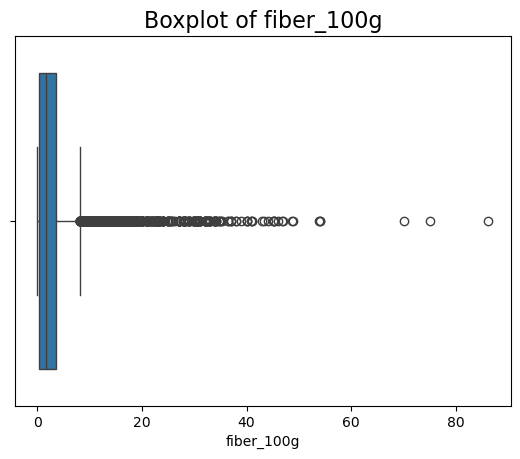

In [179]:
sns.boxplot(x=X['fiber_100g'])
plt.title('Boxplot of fiber_100g', fontsize=16)
plt.show()

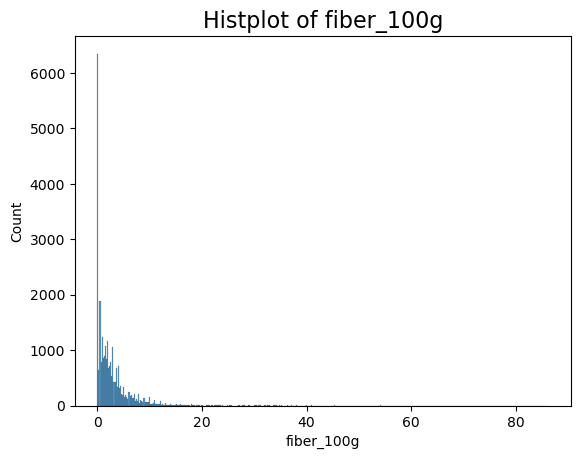

In [180]:
sns.histplot(data=X, x='fiber_100g')
plt.title('Histplot of fiber_100g', fontsize=16)
plt.show()

La forte présence d'outliers, qui à première vue ne sont pas aberrants, entraîne une forte asymétrie vers la droite, et donc une concentration des valeurs sur la gauche du graphique.

A ce stade, je n'identifie pas de valeurs aberrantes. Il faudrait regarder chaque produit individuellement pour les détecter, ce qui prendrait trop de temps.

### 2.8 - Feature "nutrition_grade_fr"

In [183]:
df['nutrition_grade_fr'].unique()

array(['e', 'b', 'd', 'c', 'a', nan], dtype=object)

Ces valeurs ne sont pas aberrantes

### 2.9 - Produits avec plus de 100g de nutriments

Si la somme des nutriments d'un produit est supérieures à 100g, cela signifierait qu'au moins une des valeur est aberrante.

**Rechercher les produits dont la somme des nutriments > 100g**

Pour la recherche je prends 102g comme limite à cause des éventuels arrondis qui peuvent perturber la somme.

In [187]:
mask = (df['proteins_100g'] + df['fat_100g'] + df['carbohydrates_100g'] + df['salt_100g'] + df['fiber_100g']) > 102
df.loc[mask, ['code', 'product_name', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'fiber_100g']]

,code,product_name,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,fiber_100g
35186,0038000045301,Cracklin' Oat Bran,8.16,14.30,69.4,0.7000,12.20
12996,0016000275294,Raisin Nut Bran,8.16,6.12,81.6,1.1400,12.20
170499,0884912003911,Honey Bunches of Oats,6.25,7.81,81.2,1.0700,6.25
170514,0884912004710,Grape-Nuts Cereal,10.30,1.72,81.0,1.1800,12.10
35204,0038000391200,Froot Loops,3.45,3.45,89.7,1.1800,10.30
...,...,...,...,...,...,...,...
219398,3270160741199,Poisson pané,13.00,9.30,11.0,74.0000,0.70
186936,2952350335784,Biscuit cru The Matcha - Fleur de coco,6.50,12.80,99.3,0.0200,8.90
11278,0014100097068,Oatmeal Raisin,6.50,14.50,74.2,0.7366,6.50
300851,8000090004706,Premium Saiwa Crackers Salati,11.20,12.80,72.0,3.0400,3.20


Comme il y a beaucoup de produits concernés, une recherche pour trouver la ou les valeurs erronées, prendrait trop de temps. Je vais donc supprimer ces lignes du dataset

In [189]:
df = df[~mask].copy()
df.shape

(55197, 162)

**Regénérer la cible et les features**

In [191]:
# regénérer la cible, les features
y, X = generate_target_and_features(df)
X.shape

(55197, 9)

In [192]:
y.shape

(55197,)

### 2.10 - Produits avec plus de 80% de valeurs manques

S'il y a trop de valeurs manquantes pour un produit, il sera plus difficile de trouver les vrais valeurs. Ces produits deviendrait des produits "artificiels" ayant au final les mêmes caractéristiques.

**Rechercher les produits concernés:**

In [195]:
# Nombre total de colonnes
total_features = X.shape[1]

# colonnes à compter
columns_to_check = ['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition_grade_fr']

# sous-ensemble du dataset
subset_df = df[columns_to_check]

# Seuil à partir duquel on considère qu'une ligne a 80% ou plus de valeurs manquantes
nb_nan_max = 0.8 * total_features

# Filtrer les lignes dont le nombre de valeurs manquantes est supérieur ou égal au seuil
rows_with_80_percent_nan = df[subset_df.isnull().sum(axis=1) >= nb_nan_max]

print("nombre de produits concernés :", rows_with_80_percent_nan.shape[0])

nombre de produits concernés : 10256


Comme il y a beaucoup de produits concernés, on va supprimer ces produits du dataset

**Supprimer les produits concernés:**

In [197]:
# Identifier les index des lignes à supprimer
rows_to_drop = subset_df[subset_df.isnull().sum(axis=1) >= nb_nan_max].index

# Supprimer ces lignes du DataFrame d'origine
df = df.drop(index=rows_to_drop)

**Regénérer la cible et les features**

In [199]:
# regénérer la cible, les features
y, X = generate_target_and_features(df)
X.shape

(44941, 9)

In [200]:
y.shape

(44941,)

## 3 - Identifier et traiter les valeurs manquantes

- 0
- mediane, par groupe possible (genre groupe nutriscore)
- iterative inputer (variables corrélées entre elles)
- knn

**Voici le pourcentage de valeurs manquantes par feature**

In [204]:
X_nan = X.isna().mean().sort_values()
X_nan

energy_100g           0.001802
proteins_100g         0.007521
fat_100g              0.042967
carbohydrates_100g    0.045126
salt_100g             0.055317
sugars_100g           0.058632
saturated-fat_100g    0.060702
nutrition_grade_fr    0.079905
fiber_100g            0.392804
dtype: float64

In [205]:
df_nan = df.loc[:,['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition_grade_fr']].isna().mean().sort_values()
df_nan

energy_100g           0.001802
proteins_100g         0.007521
fat_100g              0.042967
carbohydrates_100g    0.045126
salt_100g             0.055317
sugars_100g           0.058632
saturated-fat_100g    0.060702
nutrition_grade_fr    0.079905
fiber_100g            0.392804
dtype: float64

### 3.1 - Rechercher les corrélations entre les features

**Visualiser la matrice de corrélation entre les features quantitatives**

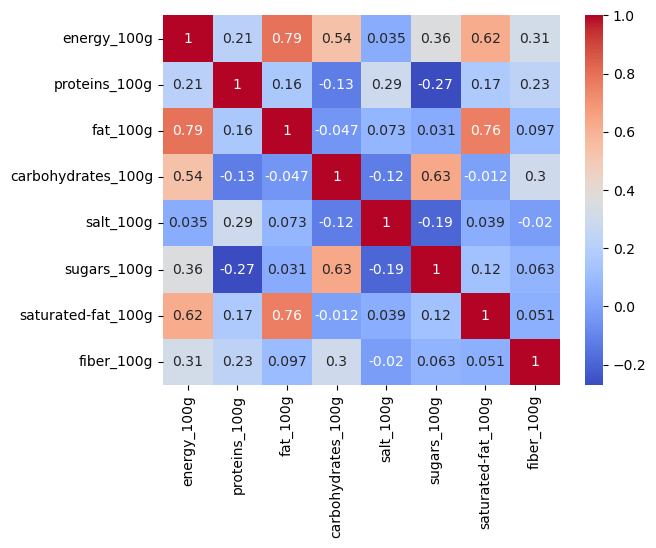

In [207]:
# Calculer la matrice de corrélation
list_quantitative_features = ['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g']
correlation_matrix = X[list_quantitative_features].corr()

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Afficher la heatmap
plt.show()

On constate :
- une corrélation évidente entre "fat" et "saturated_fat", corrélation par définition.
- une corrélation entre l'"energy" et "fat", et faible entre l'energy et "saturated_fat".
- une corrélation évidente entre les carohydrates et les sucres.
- une légère corrélation entre l'energy et les carbohydrates.

**Visualiser les corrélations entre la feature nutrition_grade_fr et les features quantitatives**



In [210]:
# Créer une fonction générique pour créer et afficher les boxplots
def build_boxplot(y_indicator, x_indicator, df):
    sns.boxplot(y=y_indicator, x=x_indicator, data=df)
    plt.title('Boxplot of ' + y_indicator + ' by ' + x_indicator, fontsize=16)
    plt.ylabel(y_indicator, fontsize=14, fontweight='bold')
    plt.xlabel(x_indicator, fontsize=14, fontweight='bold')
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)  
    plt.show()

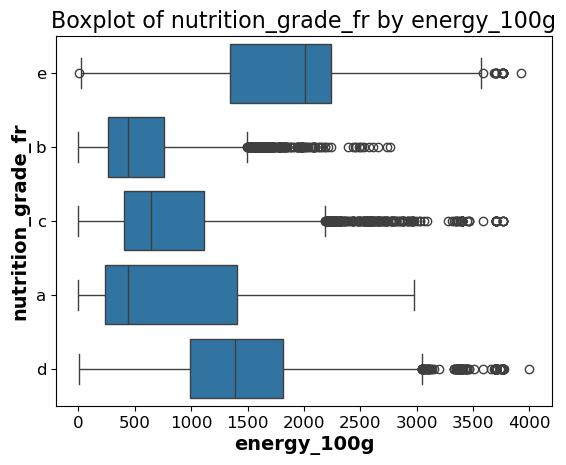

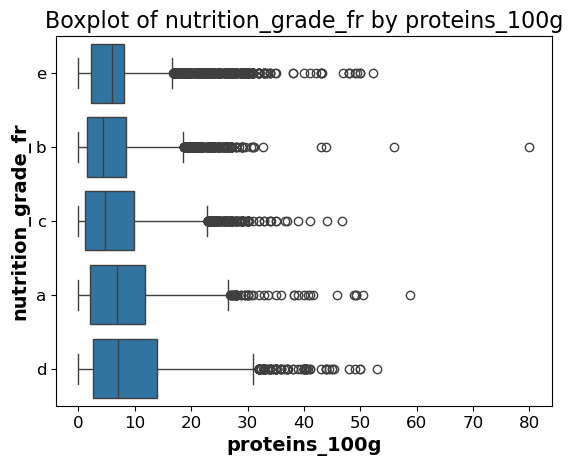

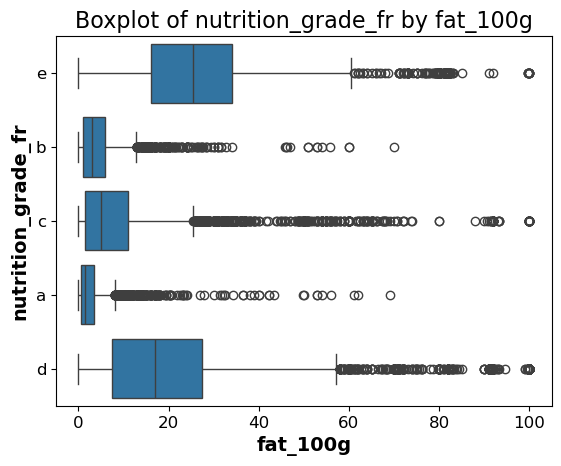

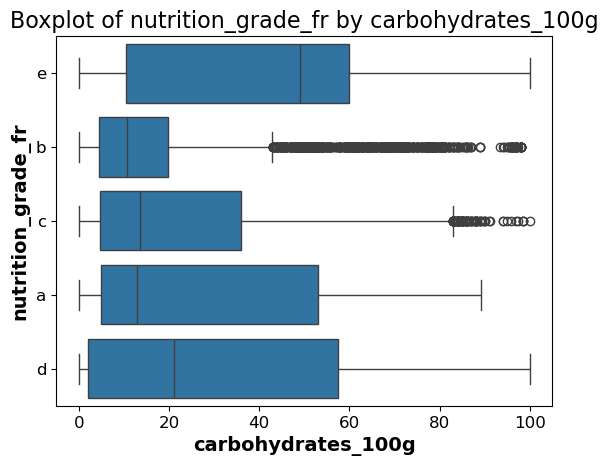

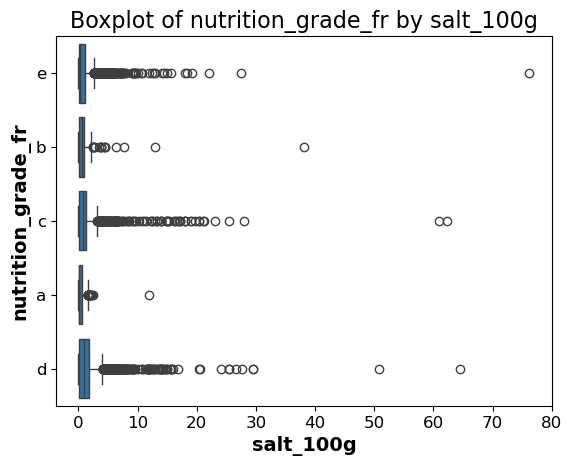

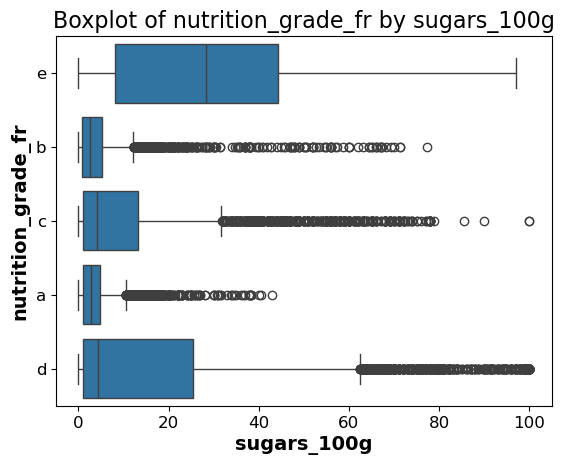

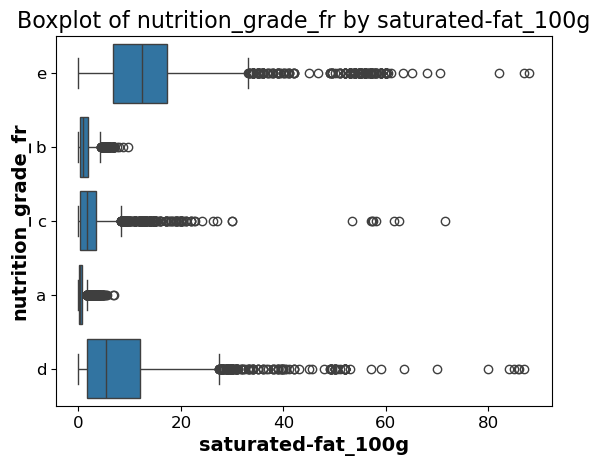

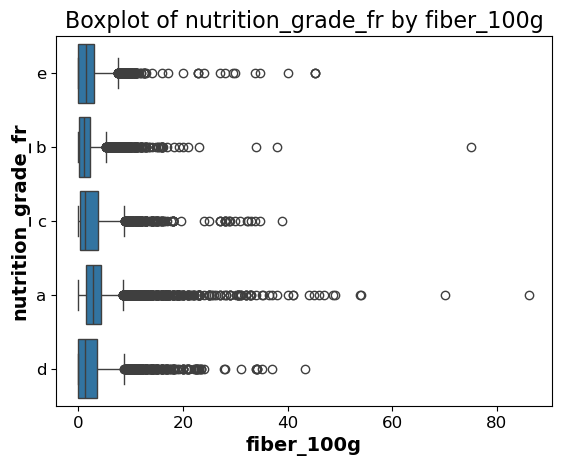

In [211]:
# Afficher les boxplots des features quantitatives par nutrition_grade_fr
for quantitative_feature in list_quantitative_features:
    build_boxplot('nutrition_grade_fr', quantitative_feature, X)

On observe une très forte corrélation entre la feature "nutrition_grade_fr" et la feature "energy". La médiane de l'energy varie fortement d'un nutrition_grade à l'autre, ensuivant l'ordre de croissance a, b, c, d, e.
Il devrait être possible de déterminer les valeurs manquantes du nutrition_grade à partir de l'energy.

Combien de produits dont l'energy et nutrition_grade sont manquantes ?

In [213]:
mask = df['energy_100g'].isna() & df['nutrition_grade_fr'].isna()
sample = df.loc[mask, ['product_name', 'code', 'energy_100g', 'nutrition_grade_fr']]
print('Il y a', str(sample.shape[0]), "produits dont l'energy et nutrition_grade sont manquantes.")

Il y a 67 produits dont l'energy et nutrition_grade sont manquantes.


Il va donc falloir déterminer l'energy avant le nutrition_grade_fr.

### 3.2 - Visualiser la distribution des features

In [216]:
# Créer une fonction pour construire et afficher les histogrammes
def build_histplot(df, x):
    sns.histplot(data=df, x=x)
    plt.title('Histplot of ' + x, fontsize=16)
    plt.xlabel(x, fontsize=14, fontweight='bold')
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)  
    plt.show()

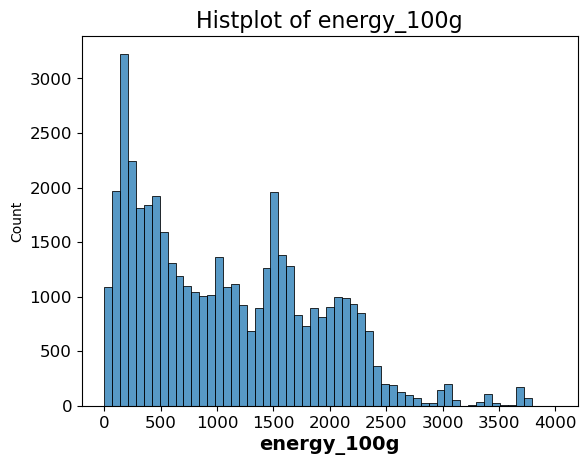

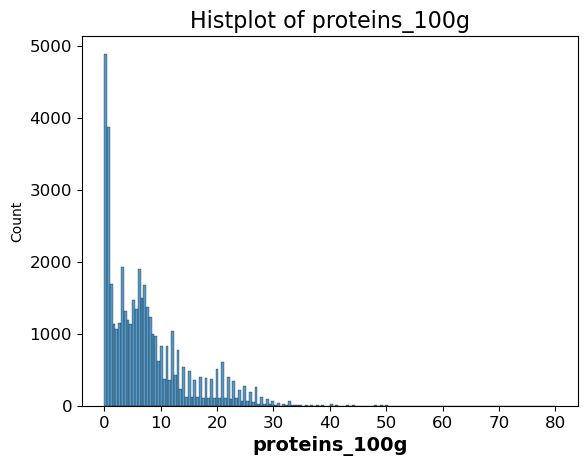

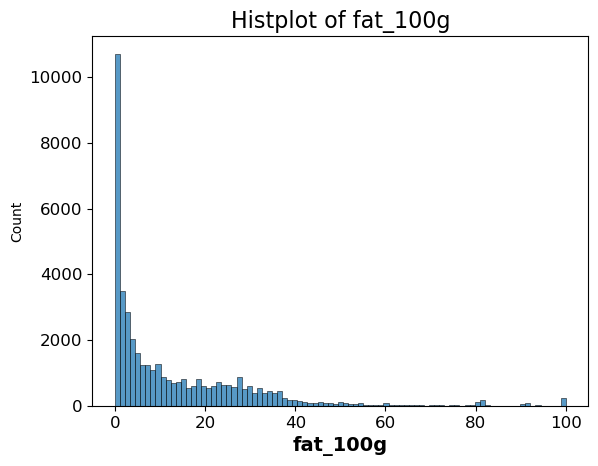

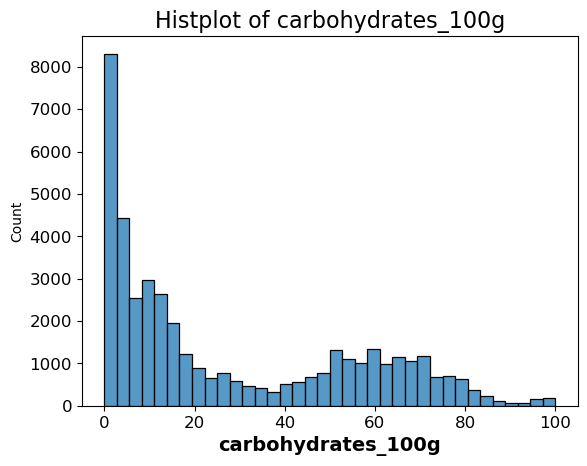

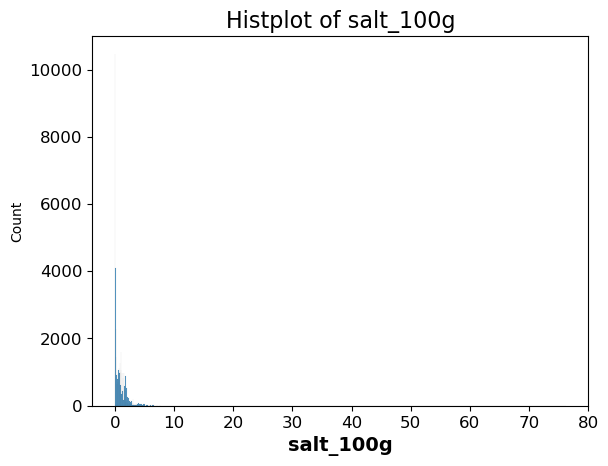

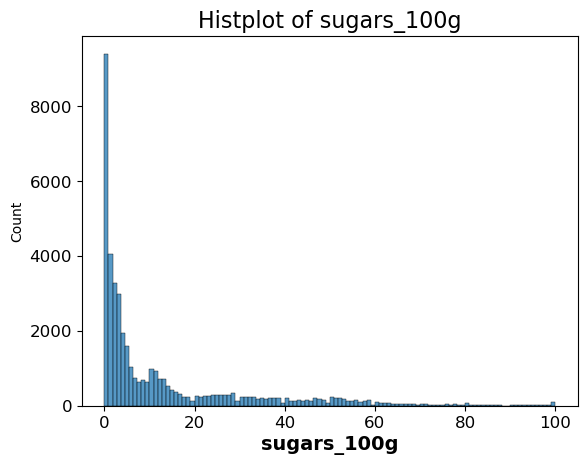

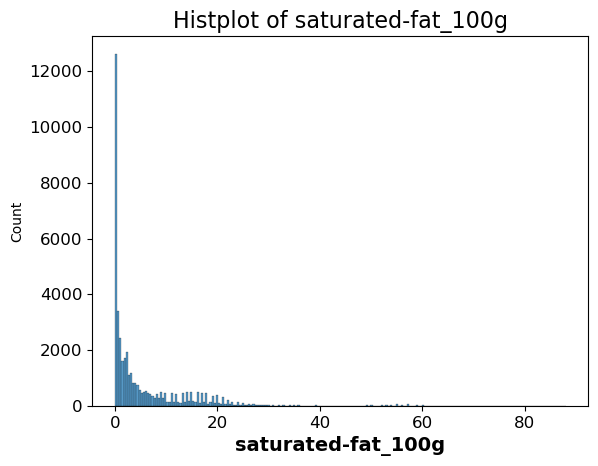

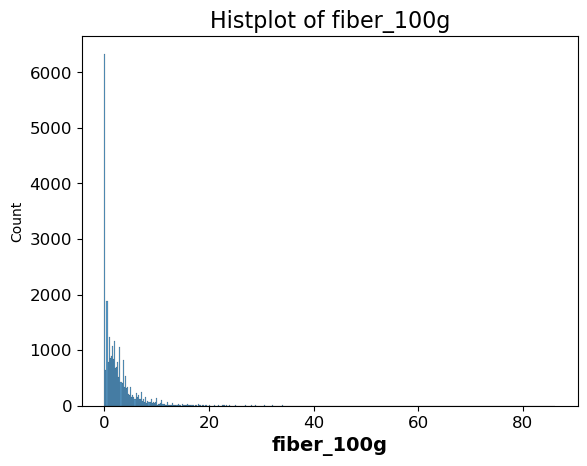

In [217]:
for quantitative_feature in list_quantitative_features:
    build_histplot(X, quantitative_feature)

Les distributions de toutes les features sont asymétriques. La moyenne ne peut donc pas être utilisée pour remplacer les valeurs manquantes.

### 3.3 - Traiter les valeurs manquantes de la feature "proteins"

Il y a très peu de valeurs manquantes pour cette feature. Elle n'est corrélée à aucune autre variable. Comme sa distribution est asymétrique, on peut utiliser la médiane.

**Calculer la médiane**

In [220]:
median = df['proteins_100g'].median()
print('La médiane pour la feature "proteins_100g" est:', median, 'g')

La médiane pour la feature "proteins_100g" est: 6.0 g


**Remplacer les valeurs manquantes par la médiane**

In [222]:
mask = df['proteins_100g'].isna()
print(df.loc[mask].shape)
df.loc[mask, 'proteins_100g'] = median

(338, 162)


In [223]:
print(df.loc[mask].shape)

(338, 162)


### 3.4 - Traiter les valeurs manquantes de la feature "salt"

Il y a 5,5 % de valeurs manquantes. Cette variable n'est correlée à aucune autre, sa distribution est asymétrique. Et il faut faire attention à la présence de quelques outliers qui viennent biaiser la distribution. Par exemple le produit "sel" qui va contenir 100g de sel pour 100g de produit.

Je vais remplacer les valeurs manquantes par la médiane, mais avant je vais exclure du calcul les outliers.

**Créer un échantillon de la variable "salt_100g" sans les plus forts outliers**

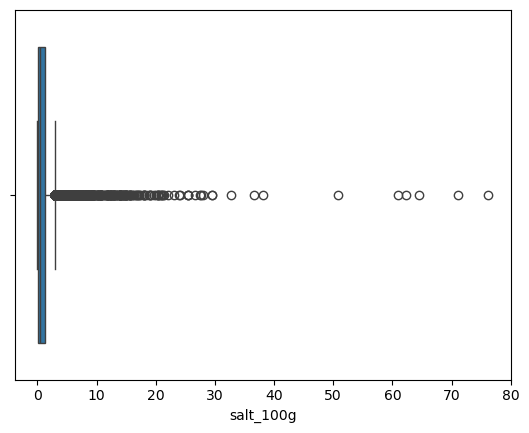

In [225]:
sns.boxplot(x='salt_100g', data=df)
plt.show()

D'après ChatGPT, certains produits peuvent atteindre 15g de sel pour 100g. Par exemple la sauce Soja.

Par conséquent je choisis de retirer les produits dont la quantité de sel est > 15g.

In [227]:
mask = df['salt_100g'] > 15
sample = df.loc[~mask]

Voici la boxplot après suppression des 60 produits

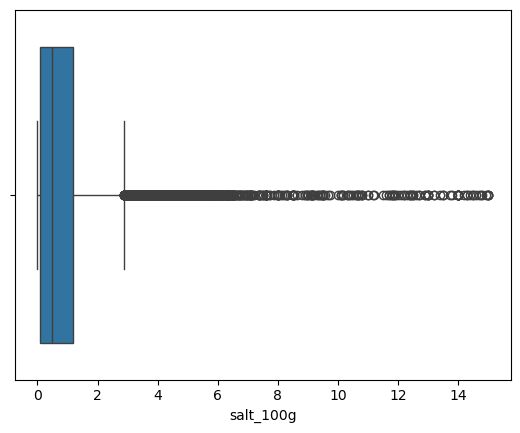

In [229]:
sns.boxplot(x='salt_100g', data=sample)
plt.show()

**Calculer la médiane de cet échantillon**

In [231]:
median = sample['salt_100g'].median()
print('La médiane pour la feature "salt_100g" est:', median, 'g')

La médiane pour la feature "salt_100g" est: 0.5 g


**Remplacer les valeurs manquantes par la médiane**

In [233]:
mask = df['salt_100g'].isna()
print(df.loc[mask].shape)
df.loc[mask, 'salt_100g'] = median

(2486, 162)


In [234]:
mask = df['salt_100g'].isna()
print(df.loc[mask].shape)

(0, 162)


### 3.5 - Traiter les valeurs manquantes des features "fat" et "saturated-fat"

Il y a 4% de valeurs manquantes pour "fat" et 6% pour "staruated-fat". "fat" est correlée aux features "energy", "saturated_fat", et 'nutrition_grade_fr'.

Il est intéressant d'utiliser ici l'outil IterativeImputer de la librairie Scikit-learn, notamment car elle est particulièrement utile lorsqu'il y a des valeurs manquantes dans plusieurs colonnes simultanément.

**Remplacer les valeurs manquantes avec IterativeImputer**

In [453]:
# Sélectionner les colonnes à imputer
columns_to_impute = ['fat_100g', 'saturated-fat_100g']

# Extraire ces colonnes dans un nouveau DataFrame
df_to_impute = df[columns_to_impute]

# Créer un objet IterativeImputer
imputer = IterativeImputer(random_state=0)

# Imputation des colonnes sélectionnées
imputed_data = imputer.fit_transform(df_to_impute)

# Convertir le résultat en DataFrame
df_imputed = pd.DataFrame(imputed_data, columns=columns_to_impute).reset_index(drop=True)

# 3. Réintégrer les colonnes imputées dans le DataFrame original
df.reset_index(drop=True, inplace=True)
df[columns_to_impute] = df_imputed

In [449]:
print(df_imputed[['fat_100g', 'saturated-fat_100g']])

        fat_100g  saturated-fat_100g
0       2.500000            1.200000
1       3.000000            1.200000
2       3.000000            1.400000
3       3.000000            1.400000
4       2.200000            0.600000
...          ...                 ...
44936  13.086045            5.358062
44937  13.086045            5.358062
44938  99.900000           37.962320
44939   1.200000            0.894083
44940  13.086045            5.358062

[44941 rows x 2 columns]


In [451]:
df.reset_index(drop=True, inplace=True)
df_copie = df.copy()
df_copie.shape
df_copie[['fat_100g', 'saturated-fat_100g']] = df_imputed[['fat_100g', 'saturated-fat_100g']]

df_nan = df_copie.loc[:,['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition_grade_fr']].isna().mean().sort_values()
df_nan

proteins_100g         0.000000
fat_100g              0.000000
salt_100g             0.000000
saturated-fat_100g    0.000000
energy_100g           0.001802
carbohydrates_100g    0.045126
sugars_100g           0.058632
nutrition_grade_fr    0.079905
fiber_100g            0.392804
dtype: float64

In [455]:
df_nan = df.loc[:,['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition_grade_fr']].isna().mean().sort_values()
df_nan

proteins_100g         0.000000
fat_100g              0.000000
salt_100g             0.000000
saturated-fat_100g    0.000000
energy_100g           0.001802
carbohydrates_100g    0.045126
sugars_100g           0.058632
nutrition_grade_fr    0.079905
fiber_100g            0.392804
dtype: float64

On voit bien qu'il n'y a plus de valeurs manquantes pour "fat" et "saturated-fat".

In [459]:
print(df_to_impute.isna().sum())

fat_100g              1931
saturated-fat_100g    2728
dtype: int64


In [457]:
print(df_imputed.isna().sum())

fat_100g              0
saturated-fat_100g    0
dtype: int64


In [461]:
df_imputed.shape

(44941, 2)

### 3.6 - Traiter les valeurs manquantes des features "carbohydrates" et "sugars"

Il y a 4,5% de valeurs manquantes pour "carbohydrates" et 5,8% pour "sugars". "carbohydrates" et "sugars" sont correlées.

Il est intéressant d'utiliser ici l'outil IterativeImputer de la librairie Scikit-learn, car elle est particulièrement utile lorsqu'il y a des valeurs manquantes dans plusieurs colonnes simultanément.

**Remplacer les valeurs manquantes avec IterativeImputer**

In [469]:
# Sélectionner les colonnes à imputer
columns_to_impute = ['carbohydrates_100g', 'sugars_100g']

# Extraire ces colonnes dans un nouveau DataFrame
df_to_impute = df[columns_to_impute]

# Créer un objet IterativeImputer
imputer = IterativeImputer(random_state=0)

# Imputation des colonnes sélectionnées
imputed_data = imputer.fit_transform(df_to_impute)

# Convertir le résultat en DataFrame
df_imputed = pd.DataFrame(imputed_data, columns=columns_to_impute).reset_index(drop=True)

# 3. Réintégrer les colonnes imputées dans le DataFrame original
df.reset_index(drop=True, inplace=True)
df[columns_to_impute] = df_imputed

In [471]:
df_nan = df.loc[:,['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition_grade_fr']].isna().mean().sort_values()
df_nan

proteins_100g         0.000000
fat_100g              0.000000
carbohydrates_100g    0.000000
salt_100g             0.000000
sugars_100g           0.000000
saturated-fat_100g    0.000000
energy_100g           0.001802
nutrition_grade_fr    0.079905
fiber_100g            0.392804
dtype: float64

### 3.7 - Traiter les valeurs manquantes de l'energy

Il y a 0.001 % de valeurs manquantes pour l'energy. Par définition, l'energy en kjoules est déterminée par la formule suivante : energy = 17 *proteins + 37 * fat + 17 * carbohydrates

On peut donc calculer les valeurs manquantes de l'energy en utilisant la formule ci-dessus.

**Remplacer les valeurs manquantes par la formule : energy = 17 x proteins + 37 x fat + 17 x carbohydrates**

In [477]:
mask = df['energy_100g'].isna()
df.loc[mask, 'energy_100g'] = 17 * df['proteins_100g'] + 17 * df['carbohydrates_100g'] + 37 * df['fat_100g'] 

In [479]:
df_nan = df.loc[:,['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition_grade_fr']].isna().mean().sort_values()
df_nan

energy_100g           0.000000
proteins_100g         0.000000
fat_100g              0.000000
carbohydrates_100g    0.000000
salt_100g             0.000000
sugars_100g           0.000000
saturated-fat_100g    0.000000
nutrition_grade_fr    0.079905
fiber_100g            0.392804
dtype: float64

### 3.8 - Traiter les valeurs manquantes de "nutrition_grade_fr"

Il y a 7,9% de valeurs manquantes. Il s'agit d'une variable catégorielle, qui nécessite une approche différente des variables précédentes. On a vu qu'elle l'energy, les carbohydrates, et fat, se dispersaient différemment selon la valeur du nutrition_grade. Cela sous-entend une corrélation, entre le nutrition_grade et ces variables quantitatives. Il serait intéressant ici d'utiliser l'imputation KNN (voisin le plus proche) pour remplacer les valeurs manquantes.

**Remplacer les valeurs manquantes avec KNN**

### 3.3 - Traiter les valeurs manquantes de la feature "fiber"

Il y a 39% de valeurs manquantes pour fiber_100g. Il n'est donc pas conseillé d'utiliser les médianes ou moyennes. On ne peut pas non plus utiliser la somme des nutriments = 100g , car on ne connait pas la quantité d'eau des produits.

Par ailleurs, "fiber" n'est correlée à aucune autre variable.




## 4 - Effectuer les analyses uni-variées et bi-variées

## 5 - Réaliser une analyse multi-variée

## 6 - RGPD